<!--Header-->
<div>
    <div class="row" style="color: #4D4D4D;font-size: 15px;padding-bottom: 20px">
        <div class="col-md-7">
            <img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" alt="Logo UOC" class="img-responsive" style="margin:20px 0px 0px">
        </div>
        <div class="col-md-5">
            <h1 style="margin:15px 0px 0px;font-size: 40px;">PRA 2</h1>
            <div style="text-align:left;margin-top: 5px;"></div>
        </div>
    </div>
    <div class="row" style="background: #FCB517;padding: 10px 20px;">
        <div class="col-md-6">
            <div>Minería de datos</div>
        </div>
        <div class="col-md-6">
            <div style="text-align:right;">Autor: Gerard-Josep Alcalde Gascón <span style="margin-left: 30px;"></span></div>
        </div>
    </div>
</div>
<!--/Header-->

# 1. Introducción

En esta práctica se van a aplicar técnicas de machine learning con el objetivo de generar unos modelos analíticos de los datasets de los que diponemos que sean capaces de aportar una mayor información sobre los tumores de las pacientes en el pecho.

Primero se tratará de generar un modelo no supervisado de clasificación basado en distancias y obtener los resultados de este, que nos servirá como punto de partida para el resto de ejercicios. Además se ha optado por evaluar en este primer punto los distos datasets que se han importado en la PRA1 con la intención de evaluar cual era más adecuado.

A continuación, se cambiará la métrica utilizada en el modelo anterior y se tratará de determinar los efectos de esta en nuestro modelo y que métrica es más apropiada para este caso práctico.

Para finalizar con los modelo no supervisados se generará un modelo con DBSCAN y OPTICS evaluando la importancia de epsilon y minPts en nuestros resultados.

También trataremos con un modelo supervisado de árbol de decisión, evaluando su calidad mediante las curvas ROC y las matrices de confusión. Además se evaluarán también unos modelos con Gradient Tree Boosting y con Random Forest para tratar de evaluar la influencia de un modelo con boosting y de un modelo que genere múltiples árboles de decisión.

A continuación, crearemos un modelo supervisado con k-NN para comparar sus resultados con los de los modelos básados en árboles de decisión.

Finalmente se comentarán las limitaciones del modelo y las consideraciones que hay que tener al utilizarlo.

## 1.1. Objetivos

Los objetivos de esta práctica son:
- Aplicar un modelo no supervisado basado en distancia sobre nuestro conjunto de datos y analizar sus resultados.
- Determinar que dataset de los escogidos en la Práctica 1 tiene un mejor comportamiento.
- Emplear distintas métricas en el modelo no supervisado.
- Aplicar un modelo no supervisado basado en distancia como DBSCAN y OPTICS.
- Aplicar un modelo supervisado basado en árboles de decisión y compararlo con otro modelo que emplee una técnica de boosting.
- Aplicar un modelo supervisado distinto y compararlo con el modelo basado en árboles de decisión.
- Estudiar las limitaciones del dataset y los riesgos de uso

## 1.2. Importación de los datos de la PRA 1

Chunks de la prácitca 1

In [1]:
# Data wrangling
import pandas as pd
import numpy as np

# Ploting
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

# For combinatory in the plotting
import itertools

# Unsupervised models
# K-means
from pyclustering.cluster.kmeans import kmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.silhouette import silhouette
from pyclustering.utils.metric import distance_metric, type_metric

# DBSCAN and OPTICS
from sklearn import metrics
from sklearn.cluster import DBSCAN, OPTICS, cluster_optics_dbscan

# Supervised models
# Decision trees
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, 
silhouette_samples, silhouette_score)


# Random forests
from sklearn.ensemble import RandomForestClassifier 
from sklearn.datasets import make_classification

# Defining the different plot parameters to get a uniform look.
sns.set_theme()
sns.set_palette(palette="pastel")

# Gradient Tree Boosting
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

# K Neighbours classifier
from sklearn.neighbors import KNeighborsClassifier

Importamos el dataset y lo almacenamos como dataframe

In [2]:
df = pd.read_csv("breast_cancer_data.csv")
df = df.drop(columns=['Unnamed: 32'])

Generamos los múltiples dataframes que emplearemos para generar el dataframe definitivo. Además de modificar algunas columnas para una mejor comprensión de los datos.

In [3]:
# Old and new column names for the dataset
columns_mean = ["id", "diagnosis", "radius_mean", "texture_mean", "smoothness_mean", "compactness_mean", "concavity_mean", "concave points_mean", "symmetry_mean", "fractal_dimension_mean"]
columns_worst = ["id", "diagnosis", "radius_worst", "texture_worst", "smoothness_worst", "compactness_worst", "concavity_worst", "concave points_worst", "symmetry_worst", "fractal_dimension_worst"]
columns_se = ["id", "diagnosis", "radius_se", "texture_se", "smoothness_se", "compactness_se", "concavity_se", "concave points_se", "symmetry_se", "fractal_dimension_se"]
new_columns = ["id", "diagnosis", "radius", "texture", "smoothness", "compactness", "concavity", "concave points", "symmetry", "fractal_dimension"]

# Generation of the mean atributes dataset
df_EDA_mean = df[columns_mean]
df_EDA_mean.columns = new_columns
df_EDA_mean.loc[df_EDA_mean["diagnosis"] == "B", "register"] = "Mean - Benign"
df_EDA_mean.loc[df_EDA_mean["diagnosis"] == "M", "register"] = "Mean - Malign"

# Generation of the worst atributes dataset
df_EDA_worst = df[columns_worst]
df_EDA_worst.columns = new_columns
df_EDA_worst.loc[df_EDA_worst["diagnosis"] == "B", "register"] = "Worst - Benign"
df_EDA_worst.loc[df_EDA_worst["diagnosis"] == "M", "register"] = "Worst - Malign"

# Generation of the worst atributes dataset
df_EDA_se = df[columns_se]
df_EDA_se.columns = new_columns

#Generate one unique dataset that can be separated by mean and worst registers
df_EDA = pd.concat([df_EDA_mean, df_EDA_worst], ignore_index=True)

/Users/gerardalcaldegascon/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/gerardalcaldegascon/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Generamos unos dataframes ya simplificados de cada una de los 3 tipos de atributos que tenemos.

In [4]:
# Mean dataset
columns_mean = ["radius_mean", "texture_mean", "smoothness_mean", "compactness_mean", "concavity_mean", "concave points_mean", "symmetry_mean", "fractal_dimension_mean"]
df_mean_norm = (df[columns_mean]-df[columns_mean].min())/(df[columns_mean].max()-df[columns_mean].min())

# Worst dataset
columns_worst = ["radius_worst", "texture_worst", "smoothness_worst", "compactness_worst", "concavity_worst", "concave points_worst", "symmetry_worst", "fractal_dimension_worst"]
df_worst_norm = (df[columns_worst]-df[columns_worst].min())/(df[columns_worst].max()-df[columns_worst].min())

# SE dataset
columns_se = ["radius_se", "texture_se", "smoothness_se", "compactness_se", "concavity_se", "concave points_se", "symmetry_se", "fractal_dimension_se"]
df_se_norm = (df[columns_se]-df[columns_se].min())/(df[columns_se].max()-df[columns_se].min())

Generamos un datframe empleando PCA

In [5]:
# Generate the dataset for the PCA and the list of features
features = columns_mean + columns_worst + columns_se
df_PCA = df[features]

# Separate the features from the target
x = df_PCA.loc[:, features].values

# Standarizing the features
x_scaled = StandardScaler().fit_transform(x)

# Instatianting pca with all the dimensions
pca = PCA(n_components=24)

# Obtaining the principal components
pca.fit(x_scaled) 

# Convert the data with the PCA dimensions
X_pca = pca.transform(x_scaled) 

# Obtain explained variance ratio
cum_var = pca.explained_variance_ratio_

Dataframe definitivo obtenido del PCA

In [6]:
# Generation of the list of names of the principal components
PC_names = ["PC{}".format(i+1) for i in range(24)]

# Dataframe of the principal components and final dataset with the pacient id and the diagnosis.
df_principal = pd.DataFrame(data = X_pca, columns = PC_names)
df_PCA_def = pd.concat([df_EDA_mean.loc[:,["id", "diagnosis"]], df_principal.loc[:,["PC1", "PC2", "PC3", "PC4", "PC5", "PC6"]]], axis = 1)

Finalmente, se han obtenido 7 dataframes que se emplearán con el objetivo de realizar una comparativa de los resultados obtenidos por cada uno de ellos. Por un lado se generan dos datasets con los atributos que han mostrado ofrecer una mayor correlación con el atributo objetivo en el conjunto **mean** y por otro lado con ambos conjuntos. Por otro lado, se generarán 4 datasets, el que incluya todos los atributos, y el que incluya todos los atributos excepto **fractal_dimension**, **symmetry** y **smoothness** tanto para **mean** como para **worst**. Además en los datasets 3-6 también se incluirá el error estándar de **radius**. Finalmente, se considerará el dataset del PCA. A continuación se detallan estos datasets:
- Dataset 1: [id, diagnosis, radius, concavity, concave points] en la lectura **mean**
- Dataset 2: [id, diagnosis, radius, concavity, concave points] en las lecturas **mean** y **worst**
- Dataset 3: [id, diagnosis, radius, texture, compactness, concavity, concave points] en la lectura **mean** y **radius_se**
- Dataset 4: [id, diagnosis, radius, texture, compactness, concavity, concave points  en las lecturas **mean** y **worst** y **radius_se**
- Dataset 5: [id, diagnosis, radius, texture, smoothness, compactness, concavity, concave points, symmetry, fractal_dimension] en la lectura **mean** y **radius_se**
- Dataset 6: [id, diagnosis, radius, texture, smoothness, compactness, concavity, concave points, symmetry, fractal_dimension]  en las lecturas **mean** y **worst** y **radius_se**
- Dataset 7: [id, diagnosis, PC1, PC2, PC3, PC4]

In [7]:
# Dataframe 1
df_id_diag = df[["id", "diagnosis"]]
df_mean_1 = df_mean_norm[["radius_mean", "concavity_mean", "concave points_mean"]]
df_1 = pd.concat(([df_id_diag, df_mean_1]),axis=1)

# Dataframe 2
df_worst_1 = df_worst_norm[["radius_worst", "concavity_worst", "concave points_worst"]]
df_2 = pd.concat(([df_id_diag,df_mean_1, df_worst_1]),axis=1)

# Dataframe 3
df_mean_2 = df_mean_norm[["radius_mean", "texture_mean", "compactness_mean", "concavity_mean", "concave points_mean"]]
df_worst_2 = df_worst_norm[["radius_worst", "texture_worst", "compactness_worst", "concavity_worst", "concave points_worst"]]
df_3 = pd.concat(([df_id_diag, df_mean_2]),axis=1)

# Dataframe 4
df_4 = pd.concat(([df_id_diag, df_mean_2, df_worst_2]),axis=1)

# Dataframe 5
df_mean_3 = df_mean_norm[["radius_mean", "texture_mean", "smoothness_mean", "compactness_mean", "concavity_mean", "concave points_mean", "symmetry_mean", "fractal_dimension_mean"]]
df_worst_3 = df_worst_norm[["radius_worst", "texture_worst", "smoothness_worst", "compactness_worst", "concavity_worst", "concave points_worst", "symmetry_worst", "fractal_dimension_worst"]]
df_5 = pd.concat(([df_id_diag, df_mean_3]),axis=1)

# Dataframe 6
df_6 = pd.concat(([df_id_diag, df_mean_3, df_worst_3]),axis=1)

# Dataframe 7
df_7 = df_PCA_def[["id", "diagnosis", "PC1", "PC2", "PC3", "PC4"]]

# 2. Ejercicio 1

## 2.1. Introducción

En este primer ejercicio se va a aplicar un modelo no supervisado de clustering, en concreto un modelo generado a partir de k-means.

Se ha escogido k-means para este modelo ya que es un modelo que suele funcionar bastante bien en modelos de clasificación y su aplicación y evaluación es sencilla. 

K-means al tratarse de un modelo no supervisado basado en distancias requiere que los atributos tengan la misma magnitud o hayan sido previamente normalizados. Los dataframes que emplearemos han sido todos normalizados, excepto df_7, el cual corresponde al PCA y tal y como se ha verificado, todos los atributos tienen un orden muy similar.

En un primer momento se va a trabajar exclusivamente con el dataset df_7 obtenido a partir del PCA y, cuando obtengamos la solución de este evaluaremos los otros datasets para ver si hay alguno que nos proporcione una mayor precisión.

## 2.2. Aplicación de K-means

A la hora de aplicar K-means debemos empezar por una selección del número de clusters que tendremos. Técnicamente debería haber 2 grupos, los que han sido diagnosticados con un tumor benigno y los que lo han hecho con un tumor maligno. No obstante, podría ser que se generen subgrupos con un mismo diagnóstico, por ejemplo que la mayor precisión se obtenga a con 5 clústers 2 asosciados a un tumor maligno y 3 asociados a un tumor benigno. Por ello, vamos a comprobar primero con que valor de K obtenemos los mejores resultados.

En este modelo la distancia que se va a emplear en el modelo k-means será la euclidea, ya que es la más habitual y suele ser una buena opción, en el siguiente apartado se emplearán otras métricas y con ellas podremos valorar cual funciona mejor con este dataset.

Empezamos almacenando los valores de estudio en la variable X.

In [8]:
X = np.array(df_7[["PC1", "PC2", "PC3", "PC4"]])
X.shape

(569, 4)

A continuación, creamos una función que nos devuelve la predicción de un modelo de kmean empleando la librería pyclustering [1]. La función nos devolverá un dataframe con la predicción de cada observación de la muestra proporcionada además de una puntuación del modelo (suma de las distancias) y el valor promedio de silhouette. De esta forma podemos evaluar el modelo.

Ha sido necesario implementar la librería pyclustering porque scikit learn en su modelo de kmeans no permite modificar la métrica y, por tanto, no habría sido posible realizar el ejercicio 2. Aunque esta librería se podría haber empleado exclusivamente en el ejercicio 2 se ha optado por utilizarlo en ambas y así poder comparar los resultados sobre el mismo algoritmo.

Para una mejor consistencia del código con scikit learn se establecía un valor para random_state, no obstante en pyclustering no se permite establecer el random_state y, por ello, los comentarios de este proyectos pueden no coincidir completamente con lo observado si se ejecuta el código.

In [9]:
def create_kmeans_model(num_clusters, X, distance):
    initial_centers = kmeans_plusplus_initializer(X, num_clusters).initialize()
    kmeans_n = kmeans(X, initial_centers, metric=distance_metric(distance))

    kmeans_n.process()
    clusters = kmeans_n.get_clusters()
    final_centers = kmeans_n.get_centers()


    # Get predictions in order to add it to the dataframe
    list_index = np.arange(df.shape[0])
    df_kmeans = pd.DataFrame(list_index, columns=["index"])
    df_kmeans["prediction"] = ""

    for i in range(len(initial_centers)):
        for j in clusters[i]:
            df_kmeans.loc[df_kmeans["index"] == j, "prediction"] = i
    
    # Evaluate score of the model
    score = kmeans_n.get_total_wce()
    
    # Evaluate silhouette score
    sil_score = silhouette(X, clusters).process().get_score()
    sil_score = sum(sil_score)/len(sil_score)
    
    return (df_kmeans, score, sil_score)



A continuación, evaluamos k-means para un rango entre 2 y 10 clusters y evaluamos la calidad de cada modelo aplicando el método elbow.

<function matplotlib.pyplot.show(close=None, block=None)>

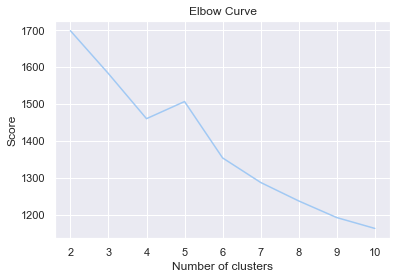

In [10]:
# Applying k-means and evaluating its results for different k clusters.
scores = []
sil_scores = []

for i in range(2,11):
    (df_kmeans, score, sil_score) = create_kmeans_model(i, X, 0)
    scores.append(score)
    sil_scores.append(sil_score)

# Plotting the results
plt.plot(list(range(2,11)), scores)
plt.xlabel("Number of clusters")
plt.ylabel("Score")
plt.title("Elbow Curve")
plt.show

Parece que se tiene un punto de inflexión entorno a 3 clusters, aunque no es muy pronunciado ya que después se vuelve a obtener la misma pendiente. De esto se concluye que los resultados obtenidos con el método elbow no son concluyentes, aunque esto se puede deber a que el número ideal de clusters sea 2 y, por ello, el modelo ya ha convergido y no obtenemos una variación sustancial de la curva.

No obstante, vamos a evaluar los modelos con silhoutte para sacar unas conclusiones finales.

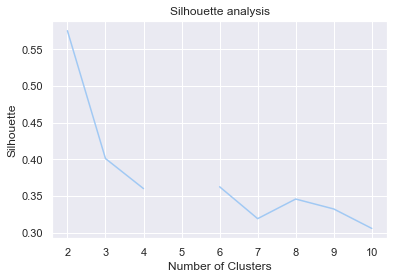

In [11]:
#Plotting the silhouette results 
plt.plot(list(range(2,11)),sil_scores) 
plt.xlabel('Number of Clusters') 
plt.ylabel('Silhouette') 
plt.title('Silhouette analysis') 
plt.show()

Tras analizar el resultado de Silhouette se obtiene que a partir de 5 clusters la precisión aumenta considerablemente. Probablemente con 5 clusters obtendremos un resultado más bueno, pero también más complejo de evaluar, por ello finalmente se opta por evaluar el modelo con dos clusters y esta información se tendrá en cuenta para futuros modelos como los basados en densidad del ejercicio 3 de esta práctica.

Además merece la pena mencionar que los valores de silhouette que se obtienen de el modelo son inválidos, por ello se producen huecos en blanco en el gráfico, esto puede ser debido a problemas en la librería ya que no es una librería ampliamente utilizada y, por ello, puede contener errores.

A continuación, generaremos un modelo de k-means con 2 clusters y mostraremos sus resultados con un pairplot para evaluar si se distinguen claramente estos dos grupos y poder identificar que variables tienen una mayor influencia.

/var/folders/rs/9rts_jsj2p32nsvfvnp3yny00000gn/T/ipykernel_99113/991365249.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_7_kmeans["kmeans_labels"] = df_kmeans["prediction"]


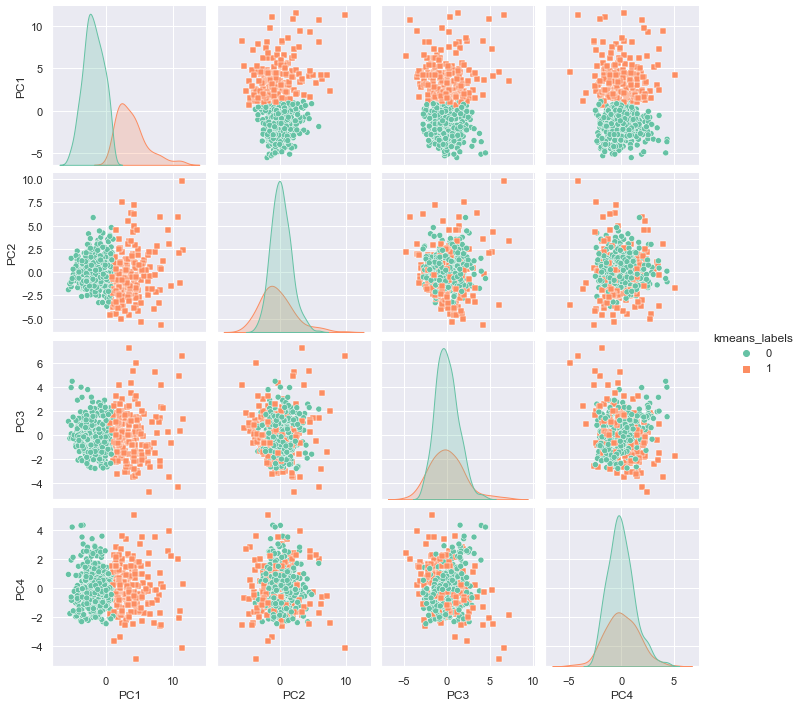

In [12]:
# Generate the k-means model with 2 clusters
(df_kmeans, score, sil_score) = create_kmeans_model(2, X, 0)

# Add predictions to the dataframe original
df_7_kmeans = df_7
df_7_kmeans["kmeans_labels"] = df_kmeans["prediction"]


# Plotting the different combinations of the four attributes
sns.pairplot(df_7_kmeans[["PC1", "PC2", "PC3", "PC4", "kmeans_labels"]], kind="scatter", hue="kmeans_labels", markers=["o", "s"], palette="Set2")
plt.show()

Se observa como la variable PC1 si que discretiza bastante bien los pacientes observándose una clara diferencia entre los dos clusters donde se observa que el valor asociado al cluster 1 para PC1 es inferior a la mostrada en las observaciones asignadas al cluster 0. En cuanto al resto de variables se observan unas curvas por lo general más dispersas en el caso del cluster 0, pero por el resto observamos unas distribuciones muy similares.

## 2.3. Evaluación del dataset más apropiado

En la práctica 1 se presentaron un total de 7 dataframes distintos que se querían evaluar para comprobar cual de ellos aportaba la mayor calidad en los resultados. A continuación se va a evaluar con un total de 2 clústers la puntuación de cada uno de ellos y así podremos determinar para un modelo no supervisado de kmeans, cual obtiene la mejor puntuación.

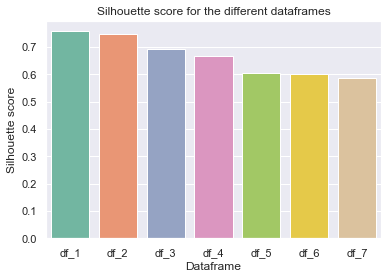

In [13]:
dataframes_list = [df_1, df_2, df_3, df_4, df_5, df_6, df_7]
dataframes_names_list = ["df_1", "df_2", "df_3", "df_4", "df_5", "df_6", "df_7"]

scores = []
df_kmeans_list = []

for df in dataframes_list:
    df_prep = df.drop(["id", "diagnosis"], axis=1)
    
    X = np.array(df_prep)
    
    (df_kmeans, score, sil_score) = create_kmeans_model(2, X, 0)
    df_kmeans_list.append(df_kmeans)
    scores.append(sil_score)

# Plot the data for each dataframe
sns.barplot(x=dataframes_names_list, y=scores, palette = "Set2")
plt.title("Silhouette score for the different dataframes")
plt.xlabel("Dataframe")
plt.ylabel("Silhouette score")
plt.show()

Silhouette es un parámetro que determina lo bien o mal agrupado que está un conjunto asignando un valor entre -1 y 1, siendo los valores cercanos a 1 los que representan una correcta asignación de los datos y los valores cercanos a -1 que los datos se han asignado a un grupo erroneo.

Según el parámetro de Silhouette se observa que los dataframes 1 y 2 son los que tienen mayor calidad, estos corresponden a los valores **radius**, **concavity** y **concave_points** de los conjuntos de datos **mean** y **worst** los cuales se habían escogido a partir de las variables que parecían tener una mayor correlación con la variable objetivo a partir del análisis exploratorio.

Los datasets 3 y 4 incluían los atributos que parecían tener una correlación con la variable objetivo, no solo los que presentaban una mayor correlación. Los cuales se quedan cerca de los resultados de los dataframes 1 y 2, pero son inferiores.

Finalmente, los dataframes 5 y 6 incluían todas las variables con el objetivo de evaluar si un dataset completo podría ayudarnos a conseguir unos resultados mejores a pesar de necesitar un mayor tiempo de cálculo. Por el valor de silhouette encontramos que sus resultados son peores.

Lo sorprendente de este resultado es que dataframe 7, el cual utiliza los datos obtenidos del PCA, con unos componentes que representaban más del 90% de la varianza, y aún así los resultados obtenidos son los de peor calidad basándonos en este parámetro. 

Para asegurarnos de estos resultados los vamos a contrastar con el valor de la precisión de los resultados para los distintos datasets. A continuación se genera una función que evalúa la precisión de una predicción, de esta forma nos será más sencillo evaluar la precisión de futuros modelos.

In [14]:
def evaluate_precision(df_predictions, df):
    # Create a dataframe containing the prediction data
    df_pred = df
    df_pred["prediction"] = df_predictions["prediction"]
    
    # Change prediction values to make them coincide with diagnosis
    df_pred.loc[df_pred.prediction == 1, "prediction"] = "M"
    df_pred.loc[df_pred.prediction == 0, "prediction"] = "B"
    
    # Evaluate precision
    df_pred_true = df_pred[df_pred["diagnosis"] == df_pred["prediction"]]
    true_rows = df_pred_true.shape[0]
    tot_rows = df_pred.shape[0]
    precision = true_rows/tot_rows
    
    # Predicted groups are assigned randomly, therefore, if prediction rate is 
    # below 50% it has been probably assigned in the opposite way, so it is changed
    
    if precision < 0.5:
        # Create a dataframe containing the prediction data
        df_pred = df
        df_pred["prediction"] = df_predictions["prediction"]
        
        # Change the prediction values
        df_pred.loc[df_pred.prediction == 0, "prediction"] = "M"
        df_pred.loc[df_pred.prediction == 1, "prediction"] = "B"
        
        precision = 1 - precision
    
    return precision, df_pred

A continuación, evaluamos la precisión de los modelos para cada dataset.

  df_name  precision
0    df_7   0.866432
1    df_5   0.889279
2    df_3   0.899824
3    df_6   0.903339
4    df_1   0.906854
5    df_4   0.926186
6    df_2   0.927944


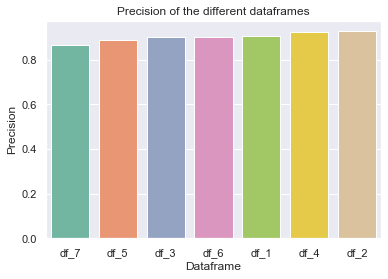

In [15]:
# Get the list of the precision of each dataset
precision_list = [evaluate_precision(df_kmeans_list[i], dataframes_list[i])[0] for i in range(7)]

# Zip precision and dataframe names and sort them:
df_precision = list(zip(dataframes_names_list, precision_list))
df_precision.sort(key=lambda tup: tup[1])

# Dataframe barplot:
df_barplot = pd.DataFrame(df_precision, columns=["df_name", "precision"])
print(df_barplot)

# Plot the precisions into a barplot
sns.barplot(data=df_barplot, x="df_name", y="precision", palette = "Set2")
plt.title("Precision of the different dataframes")
plt.xlabel("Dataframe")
plt.ylabel("Precision")
plt.show()

Se observa que el dataframe que nos da la mayor precisión es el dataframe 2 con un 93,6% de precisión muy seguido del dataframe 4. Lo que significa que incorporar los valores de los resultados **worst** nos ayuda a mejorar la precisión del modelo. Además se observa como emplear el dataframe 2, que solo incluye los datos de los atributos con mayor correlación nos da unos resultados más fiables.

En contrapartida encontramos como el dataframe 7, que incluía los resultados del PCA nos da uno de los peores resultados (un 7% menos de precisión que el dataframe 2), tal y como habíamos visto con Silhouette. Esto puede ser debido a que esas variables tratan de representar la mayor dispersión posible, pero también son la que conllevan una mayor diversidad entre sus datos.

Otro dato que es sorprendente es la precisión del dataframe 1 que resulta ser una de las peores a pesar de tener el mejor valor de silhouette.

Tras realizar estas observaciones se decide continuar el estudio con el dataframe 2.

In [16]:
# Store in X the values that will be used for future models
df_prep = df_2.drop(["id", "diagnosis", "prediction"], axis=1)
X = np.array(df_prep)

## 2.4. Evaluación del modelo con el dataframe 2

Finalmente, se van a evaluar los resultados una vez más con los datos del dataframe 2, ya que se ha observado que es el que nos aporta mayor información. Además al no ser datos extraídos de un PCA nos permitirá darle un sentido físico a los resultados del modelo.

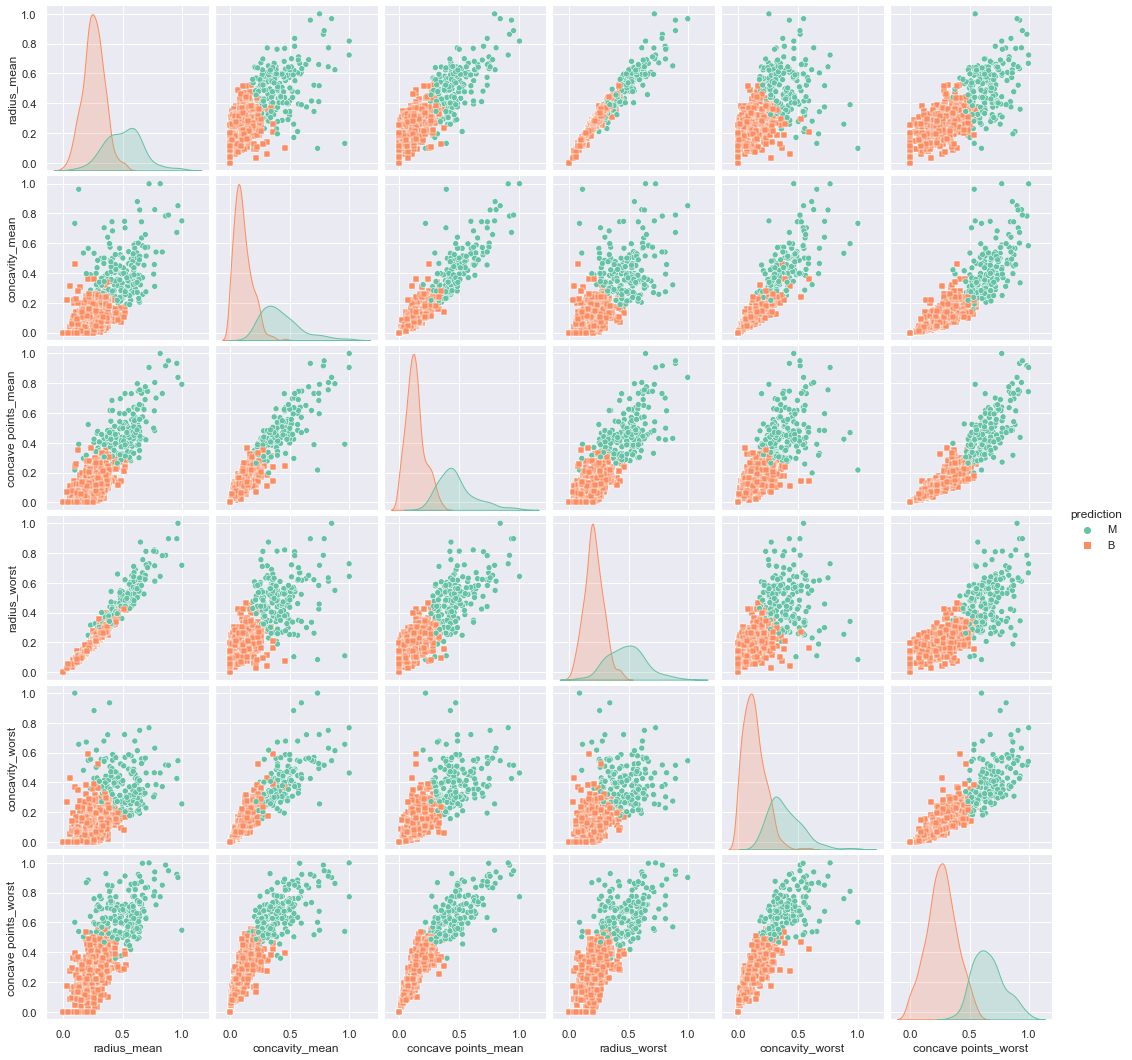

In [17]:
# Get the dataframe with the predictions from the previous functions
(precision, df_2_kmeans) = evaluate_precision(df_kmeans_list[1], dataframes_list[1])

# Create a scatterplot of the dataframe
sns.pairplot(df_2_kmeans[["radius_mean", "concavity_mean", "concave points_mean", "radius_worst", 
                          "concavity_worst","concave points_worst", "prediction"]], 
             kind="scatter", hue="prediction", markers=["o", "s"], palette="Set2")
plt.show()

De este scatterplot podemos observar como todas las variables proporcionan una clara diferenciación entre los resultados de tumores malignos y benignos, esto es debido a que este dataset ya había sido escogido entre las variables que ofrecían una mayor correlación con la variable objetivo y por ello se obtienen estos resultados tan claros en los que se observa como los tumores malignos suelen tener una mayor magnitud en todos los atributos.

Para completar este análisis se procede a evaluar que variables nos han generado un mayor número de falsas predicciones sin diferenciar entre falsos positivos o falsos negativos. Para ello generaremos una nueva columna que determine si la predicción ha sido correcta o no y, mostraremos de nuevo un scatterplot que nos permita determinar donde se encuentran los valores mal asignados y poder sacar unas conclusiones de porque ocurre esto.

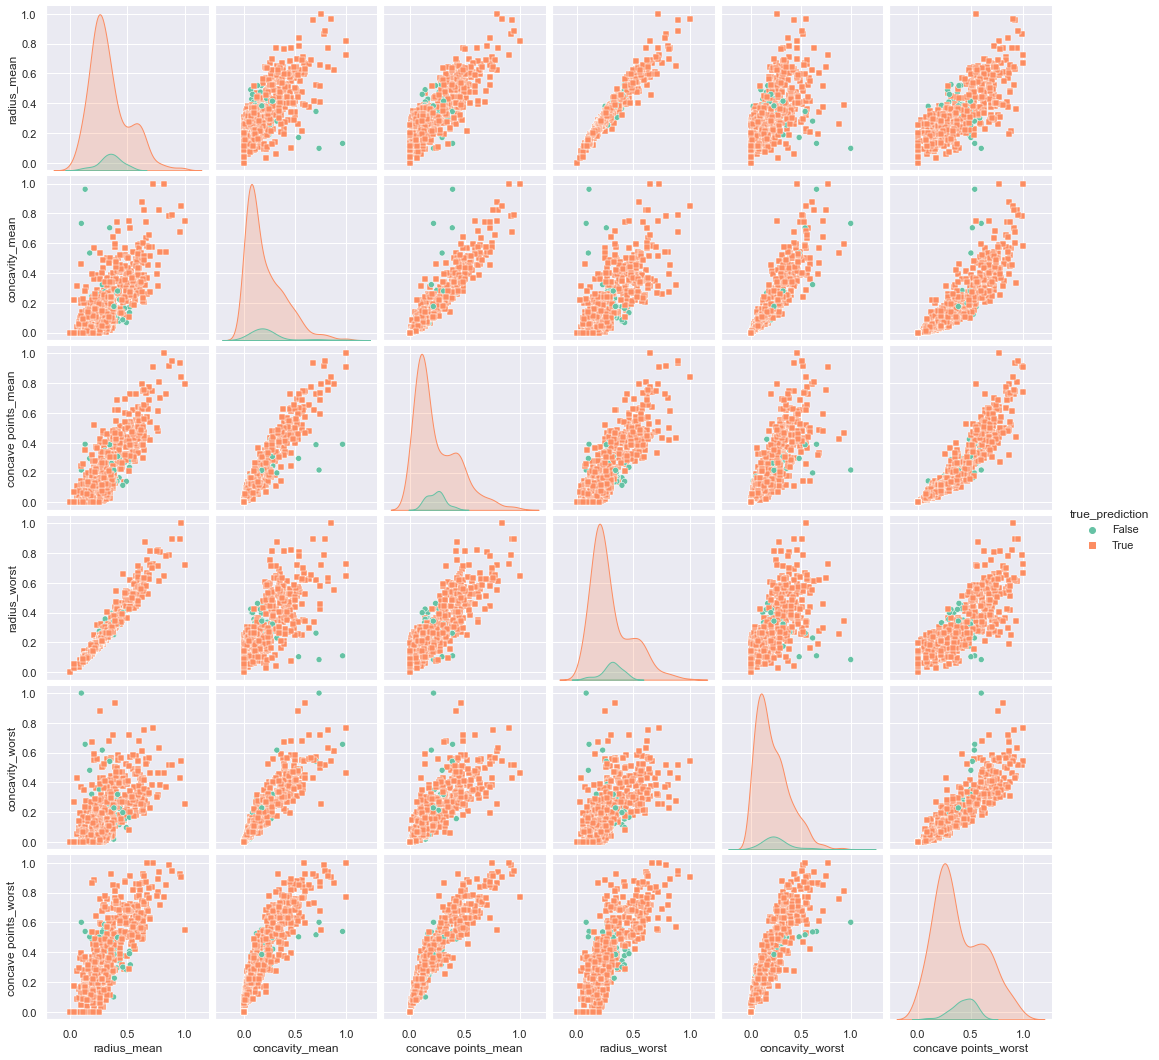

In [18]:
# Add column showing if the prediction is right or worng
df_2_kmeans["true_prediction"] = np.where(df_2_kmeans["diagnosis"] == df_2_kmeans["prediction"], True, False)


# Scatterplot showing the wrong predicted values
sns.pairplot(df_2_kmeans[["radius_mean", "concavity_mean", "concave points_mean", "radius_worst", 
                          "concavity_worst","concave points_worst", "true_prediction"]], 
             kind="scatter", hue="true_prediction", markers=["o", "s"], palette="Set2")
plt.show()

Con este scatterplot ya se puede determinar que variables nos aportan un mayor número de valores mal asignados esto se hará observando que valores mal asignados se encuentran lejos de los grupos principales.

Se observa que **concavity_mean** es la variable que muestra más resultados mal asignados al igual que **concavity_worst**. No obstante, hay que destacar que estos valores son mínimos y que la predicción que obtenemos es muy buena. Además también son los atributos que suelen mostrar una mayor dispersión.

## 2.4. Conclusiones

En este apartado se han creado múltiples modelos no supervisados de ordenación utilizando el algoritmo k-means. 

A partir de estos modelos se ha determinado en un primer momento que el número más apropiado de clusters era 2, lo cual coincide con el número de grupos que tenemos, esto se ha decidido así al no observarse un número claro de clusters ni con el método elbow ni con silhouette. Por ello, sabiendo que el número correcto de clusters era 2, se ha optado por este número.

A continuación, se ha evaluado el modelo empleando el dataframe 7 y se ha obtenido que la variable que aportaba la mayor información a la hora de determinar la asignación a un cluster era la PC1 obtenida a partir de PCA. Esto es lógico ya que al aplicar el PCA cambiamos los ejes de nuestros sistema de referencia con tal de maximizar la dispersión de las variables, y el orden que obtenemos de las variables se asocia a la dispersión que recogen, por ello PC1 es la variable que mayor dispersión recoge y, por tanto, la variable que tiene la mayor influencia a la hora de determinar la clasificación de las variables.

Después se ha decidido evaluar la eficiencia de los distintos datasets que se crearon analizando el valor promedio de silhouette de estos y su precisión. De este análisis se ha obtenido que los mejores resultados de silhouette se obtenían para los dataframes 1 y 2, que contenian los atributos con mayor correlación con la variable objetivo. A continuación, al evaluar la precisión el dataframe 1 no ha dado muy buenos resultados, comparado con el resto, pero si que lo ha hecho el dataframe 2. Por ello se ha determinado escoger el dataframe 2 para realizar un último análisis de los datos y tomarlo como referencia para el resto de apartados.

Del dataframe 2 se ha obtenido que todas las variables tienen una gran correlación con la variable objetivo discretizando de una forma apropiada los datos, tal y como era de esperar dado que ya se buscó este objetivo en el análisis exploratorio.

Finalmente, se ha tratado de analizar más en profundidad que atributos eran los que estaban produciendo un mayor número de predicciones erroneas y se ha encontrado que las variables **concavity_mean** y **concavity_worst** eran los causantes de estos, a pesar de ser dos variables que han dado un gran resultado y que se continuarán empleando a continuación.

# 3. Ejercicio 2

## 3.1. Introducción

Los métodos no supervisados de clustering como k-means se basan en la distancia entre dos muestras para determinar si deben pertenecer al mismo cluster o no. Es por ello que la forma de medir esta distancia puede ser muy relevante y generar diferencias en los resultados obtenidos. Por lo general se suele utilizar la métrica euclidea, aunque existen otras ampliamente utilizadas como la gausiana o la Manhattan.

En este ejercicio se va a generar un modelo no supervisado de clustering con el algoritmo k-means pero con una metrica distinta a la empleada en el ejercicio anterior que fue la métrica euclidea.

El objetivo del ejercicio será determinar las diferencias que se obtienen con distintas métricas y la influencia que el uso de cada una de ellas tiene.

## 3.2. Generación del modelo

A partir de la información obtenida en [2] y en [3], se obtiene que las metricas que trae incorporadas pyclustering son (con los números correspondientes para aplicarlas):
 - Euclidean: 0
 - Squared euclidean: 1
 - Manhattan: 2
 - Chebyshev: 3
 - Canberra: 5
 - Chi-square: 6
 
Estas métricas se caracterizan por [4]:

La distancia euclidea se obtiene tras realizar la raíz de la suma de las diferencias al cuadrado de las distancias en cada dimensión. Es una de las métricas más utilizadas.

La distancia euclidea cuadrada (squared euclidean), se calcula como la distancia euclidea pero sin realizar la raíz, como resultado obtenemos que esta métrica es más rápida que la distancia euclidea en aplicaciones de clustering.

La distancia Manhattan consiste en sumar la distancia en cada una de las dimensiones. Es una métrica que se computa muy rápidamente.

La distancia Chebyshev consiste en sumar la máxima distancia en cada una de las dimensiones. Es una métrica que dará muy buenos resultados con muestras en las que los resultados son muy similares y tan solo se obtienen pequeñas diferencias entre ellos además es recomendable que la distancia entre dos muestras se observe en cada atributo individualmente y no en el conjunto de total de los atributos, ya que esta diferencia no se captará. Es una métrica muy sensible a los outliers.

La distancia Canberra es una métrica ponderada de la distancia Manhattan.

La distancia Chi-square sirve para obtener la similitud entre dos vectores.

A continuación se va a generar un modelo para cada una de las métricas y a continuación se va a mostrar en un gráfico de barras primero la puntuación de minimos cuadrados, después de silhouette y finalmente la porcentaje de muestras bien asignadas, para cada una de las metricas.

Empezamos creando los modelos.

In [19]:
# Dictionary with the measures
distance_measures = {'euclidean': 0, 'squared euclidean': 1, 'manhattan': 2, 'chebyshev': 3, 
                     'canberra': 5, 'chi-square': 6}

distances_list = ['euclidean', 'squared euclidean', 'manhattan', 'chebyshev','canberra', 'chi-square']

# Define lists where the results are going to be stored
df_kmeans_list = []
scores_list = []
silhouette_list = []

# Get the predictions, scores, and silhouette scores for each model
for i in distance_measures:
    (df_kmeans, score, sil_score) = create_kmeans_model(2, X, distance_measures[i])
    df_kmeans_list.append(df_kmeans)
    scores_list.append(score)
    silhouette_list.append(sil_score)

## 3.3. Evaluación de la calidad de los distintos modelos

A continuación, vamos a representar mediante un barplot la puntuación del modelo, cabe destacar que esta puntuación corresponde a mínimos cuadrados en el caso de la distancia euclidea, pero con cada distancia varía.

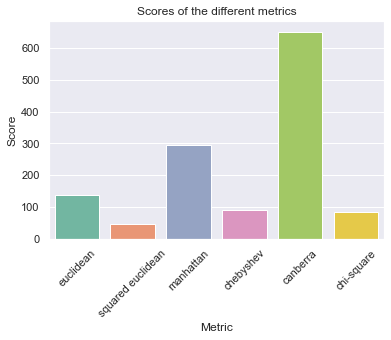

In [20]:
# Plot the scores into a barplot
sns.barplot(x=distances_list, y=scores_list, palette = "Set2")
plt.title("Scores of the different metrics")
plt.xlabel("Metric")
plt.xticks(rotation = 45)
plt.ylabel("Score")
plt.show()

Se observa que las distancis squared euclidean, chebyshev y chi-square son las que muestran mejores resultados basándonos en la puntuación que nos devuelve el modelo. En el lado contrario nos encontramos las métricas Canberra y Manhattan. Como la puntuación que devuelve el modelo no es muy fiable para comparar distintas metricas, ya que varía entre ellas, vamos a evaluar la puntuación de silhouette.

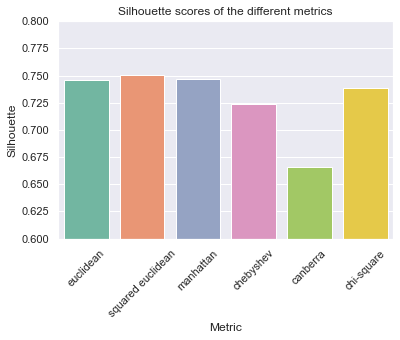

In [21]:
# Plot the silhouette score into a barplot
sns.barplot(x=distances_list, y=silhouette_list, palette = "Set2")
plt.title("Silhouette scores of the different metrics")

plt.xlabel("Metric")
plt.xticks(rotation = 45)

plt.ylabel("Silhouette")
plt.ylim([0.60, 0.80])
plt.show()

A partir de la puntuación de silhouette se observa que Squared Euclidean obtiene el mejor resultado para silhouette, aunque son muy similares a los obtenidos por las métricas Euclidean, Manhattan y un poco por detrás Chebyshev. La métrica Canberra vuelve a obtener la peor puntuación.

Finalmente, se va a analizar la precisión a la hora de predecir los resultados con cada métrica.

              metric  precision
0           canberra   0.912127
1  squared euclidean   0.919156
2          euclidean   0.927944
3         chi-square   0.927944
4          manhattan   0.929701
5          chebyshev   0.933216


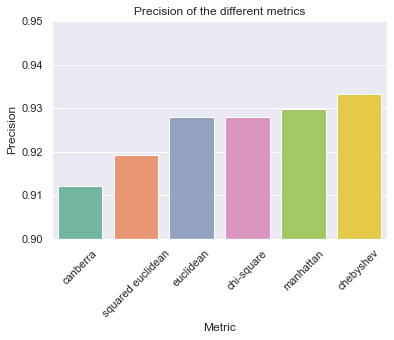

In [22]:
# Get the list of the precision of each metric
precision_list = [evaluate_precision(df_kmeans_list[i], df_2)[0] for i in range(len(df_kmeans_list))]

# Zip precision and metric names and sort them:
df_precision = list(zip(distances_list, precision_list))
df_precision.sort(key=lambda tup: tup[1])

# Dataframe barplot:
df_barplot = pd.DataFrame(df_precision, columns=["metric", "precision"])
print(df_barplot)

# Plot the precisions into a barplot
sns.barplot(data=df_barplot, x="metric", y="precision", palette = "Set2")
plt.title("Precision of the different metrics")

plt.xlabel("Metric")
plt.xticks(rotation = 45)

plt.ylabel("Precision")
plt.ylim([0.90, 0.95])

plt.show()

La precisión de todas las métricas es extremadamente elevada, siendo del 91,2% con Canberra, el que ha obtenido los peores resultados y 93,5% en Chi-square, la metrica con los mejores resultados, aunque cuatro de las métricas (Euclidean, Manhattan, Chebyshev y Chi-square) obtienen una diferencia en la precisión de menos de un 1%, por lo que todas proporcionan una precisión muy elevada.

## 3.4. Comparación de los distintos modelos

En el ejercicio anterior se había empleado la métrica euclidea, ya que suele ser la distancia empleada por defecto en la mayoría de algoritmos de clustering. Hay algunos algoritmos como k-means en la librería scikit learn, el cual emplea exclusivamente la métrica euclidea.

A partir de este análisis se obtiene que la métrica euclidea proporciona unos resultados muy buenos a pesar de no ser la métrica con los mejores resultados para este dataset. Comparado con la métrica euclidea, las métricas Manhattan, Chebyshev y Chi-square nos proporcionan unos resultados con mayor precisión en la predicción.

Era de esperar que squared euclidean tuviese una calidad peor, ya que es una versión simplificada de euclidean para mejorar su velocidad en contra de su calidad. Canberra es otra métrica más sencilla que euclidean por lo que también nos esperábamos estos resultados, aunque no nos esperábamos que fuese peor que la métrica Manhattan, al tratarse de una mejora de esta ponderando los datos.

Chebyshev nos proporciona unos resultados muy buenos, lo cual nos indica que podemos determinar la variable objetivo con el resto de atributos de forma independiente, ya que con esta métrica no se tiene en cuenta el conjunto de las variables sino cada una de ellas de forma independiente.

Chi-square es la métrica que acaba proporcionando los mejores resultados.

## 3.5. Conclusiones

Tras un análisis de las distintas métricas se obtienen distintas conclusiones de nuestro dataset y de las métricas a emplear.

Primero de todo podemos concluir que la métrica Euclidea empleada en el apartado anterior nos da unos resultados suficientemente buenos, sin tener que entrar en la mayor complejidad que supone emplear métricas alternativas, las cuales solo estarían justificadas si se demostrase una gran mejora en calidad o en tiempos de computación.

A partir de las distintas métricas se ha obtenido que la métrica Euclidea ofrece unos resultados suficientemente buenos tanto en su puntuación general, en la puntuación de silhouette y en la precisión al predecir los resultados. No obstante hay otras métricas como Chebyshev o Chi-square capaces de proporcionar unos resultados de mayor calidad.

A partir de los resultados obtenidos con estas métricas se pueden sacar otras conclusiones de los datos con los que estamos trabajando. Al obtener unos buenos resultados con la métrica Manhattan y Chebyshev deducimos que los distintos diagnósticos se diferencian en cada uno de los atributos y, no tanto, en el conjunto de estos. Esto ya se observaba previamente en los pairplots mostrados en el ejercicio anterior donde se veía que en cada una de las variables se obtenian unos valores de mayor magnitud para los tumores malignos.

# 4. Ejercicio 3

## 4.1. Introducción

En este ejercicio aplicaremos un modelo no supervisado de agregación por densidad como es DBSCAN y OPTICS. 

Primero emplearemos OPTICS con el objetivo de determinar el número minimo de puntos que debemos considerar, y los valores de epsilon que nos darán una buena predicción.

A continuación, basándonos en los valores obtenidos previamente, aplicaremos un modelo de clasificación con DBSCAN y evaluaremos su calidad.

Finalmente, compararemos los resultados obtenidos con los de los ejercicios anteriores.

## 4.2. OPTICS

En los ejercicios previos se ha observado que los clusters eran bastante densos y en muchos casos continuos, por lo que deberemos emplear un número mínimo de puntos relativamente bajo para evitar que se nos genere un único cluster, comenzaremos generando un modelo con un mínimo de 10 puntos.

Para la implementación de este modelo se han tomado como referencia las propuestas de soluciones de los compañeros proporcionadas en la asignatura [5].

In [23]:
# Create the dataframe for this exercise
df_optics = df_2.drop(["diagnosis", "id", "prediction", "true_prediction"], axis=1)

# Function to create an OPTICS model
def create_OPTICS(samples, df_sample):  
    # Create copy of the dataframe
    df = df_sample.copy()
    
    # Create an OPTICS model and fit it with our values
    clustering = OPTICS(min_samples=samples)
    labels = clustering.fit_predict(df)
    
    # Add reachability and label to each observation
    df["reachability"] = clustering.reachability_
    df["labels"] = clustering.labels_
    
    # Sort the values in the order obatined
    df = df.loc[clustering.ordering_].reset_index().drop("index", axis=1)
    
    return df

# Create an OPTICS model
df_optics_result = create_OPTICS(10, df_optics)

# Evaluate
len(df_optics_result.labels.unique())

3

A continuación se evaluará el número mínimo de puntos necesario para obtener los distintos clusters.

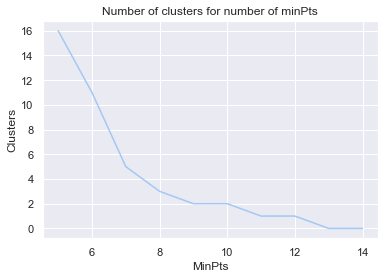

[16, 11, 5, 3, 2, 2, 1, 1, 0, 0]


In [24]:
min_points = [i for i in range(5,15)]
num_clusters = [len(create_OPTICS(i, df_optics).labels.unique())-1 for i in min_points]

# Plot the number of clusters generated for the different minPts
sns.lineplot(x=min_points, y=num_clusters)
plt.title("Number of clusters for number of minPts")
plt.xlabel("MinPts")
plt.ylabel("Clusters")
plt.show()

print(num_clusters)

Se observa que obtenemos 3 clusters considerando 8 puntos en la distancia epsilon para considerarlo un cluster y 2 cluster con 9 y 10 puntos como mínimo de puntos. Tras observar esto, emplearemos un mínimo de 9 puntos de ahora en adelante para los modelos con OPTICS, de esta forma reducimos el número de observaciones no asignadas, corriendo el riesgo de aumentar el número de observaciones mal asignadas.

A continuación, vamos a representar el reachability plot de la un modelo OPTICS con un mínimo de 9 puntos.

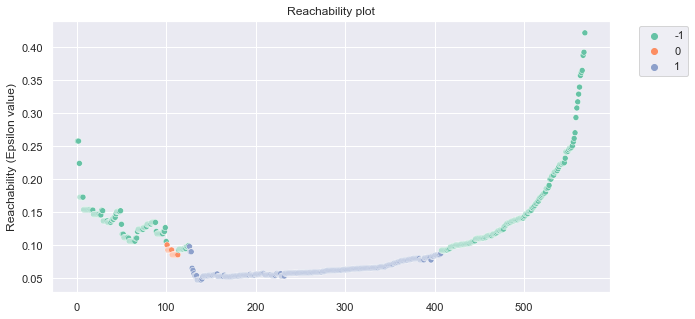

In [25]:
# Generate the OPTICS model
df_optics_def = create_OPTICS(10, df_optics)


# Scatterplot of the reachability
plt.figure(figsize=(10,5))
sns.scatterplot(data=df_optics_def, x=df_optics_def.index, y="reachability", hue="labels", palette="Set2")
plt.title("Reachability plot")
plt.ylabel("Reachability (Epsilon value)")
plt.legend(bbox_to_anchor=(1.15, 1))
plt.show()

Como podemos ver, efectivamente, se forman dos grupos pero no como esperábamos, ya que la gran mayoría de los valores aparecen como outliers y solo dos conjuntos entran dentro de un cluster. 

A partir del reachability plot observamos que no hay una gran diferenciación entre los valores de un grupo y los otros, esto es debido a que se encontraban formando un gran cluster y los valores de la zona superior correspondían a los diagnosticados como malignos y los de la zona inferior como benignos. 

No obstante, lo que estamos observando se puede deducir de este reachability plot es que los tumores que son asignados como benignos son los que generan el valle entre los puntos 100 y 500 aproximadamente, y los tumores malignos son anomalías, que en otro caso se asignarían como outliers, pero en nuestro caso se deben considerar. Estos no generan un único grupo que se agrupe, ya que un tumor maligno no tiene una carácterística propia, a diferencia de los benignos. Por ello en este caso, lo que tenemos que hacer es buscar unos valores que nos permitan encontrar un único cluster (tumores benignos) y un conjunto de outliers (tumores malignos).

Por ello vamos escogeremos un valor mínimo de puntos de 12 que nos generará un único grupo. Se escoge 12 ya que este valor producirá un mayor número de outliers, es decir tumores diagnosticados como malignos, en nuestro caso de estudio será mejor diagnosticar un tumor benigno como maligno y realizar unas pruebas adicionales donde se determine que fue un falso postivo, que no diagnosticar un tumor maligno como benigno y no tratar al paciente. Por ello, se va a tratar en todo momento de quedarnos en el lado de la seguridad y perder un poco de precisión a cambio de evitar falsos negativos.

Con este nuevo valor repetimos el reachability plot.

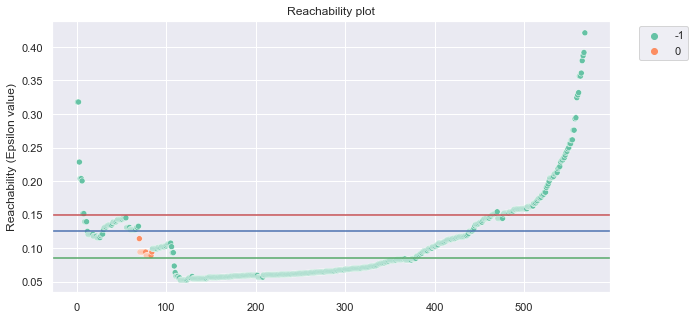

In [26]:
# Generate the OPTICS model
df_optics_def = create_OPTICS(12, df_optics)


# Scatterplot of the reachability
plt.figure(figsize=(10,5))
sns.scatterplot(data=df_optics_def, x=df_optics_def.index, y="reachability", hue="labels", palette="Set2")
plt.title("Reachability plot")
plt.ylabel("Reachability (Epsilon value)")
plt.legend(bbox_to_anchor=(1.15, 1))


# Show lines indicating the epsilon values
plt.axhline(y=0.15, color='r', linestyle='-')
plt.axhline(y=0.125, color='b', linestyle='-')
plt.axhline(y=0.085, color='g', linestyle='-')

plt.show()

Se observa que hay varios valores de epsilon que podriamos emplear en función de que agrupaciones consideremos pertenecientes al cluster central. Con un valor de 0.85 tan solo cogeríamos el valle central, descartando una gran parte de los valores por la parte superior. Por lo que quizás deberíamos aumentar este valor con 0.125 englobamos una gran parte del valle central y cogemos el máximo del lateral izquierdo, este será uno de los valores que convendrá probar. Por otro lado con 0.15 estaremos cogiendo casi todo el lateral izquierdo y la gran parte del valle, descartando los valores de la derecha.

A continuación se estudiarán estos dos valores, y se evaluará cual es más apropiado.

## 4.3. DBSCAN

A partir de los valores de epsilon y minPts obtenidos previamente con el modelo de OPTICS se procede a aplicar un modelo de DBSCAN.

In [27]:
# Create the dataframe for this exercise
df_dbscan = df_2.drop(["diagnosis", "id", "prediction", "true_prediction"], axis=1)



def create_DBSCAN(df_sample, epsilon, samples):
    df = df_sample.copy()
    
    # Create the model
    clustering = DBSCAN(eps=epsilon, min_samples = samples)
    
    # Train the model and predict the labels
    clusters = clustering.fit_predict(df)
    df["prediction_dbscan"] = clusters.tolist()
    
    # Silhouette score
    sil_scores = silhouette_samples(df, clusters)
    sil_score = sum(sil_scores)/len(sil_scores)
    
    
    return df, sil_score
 

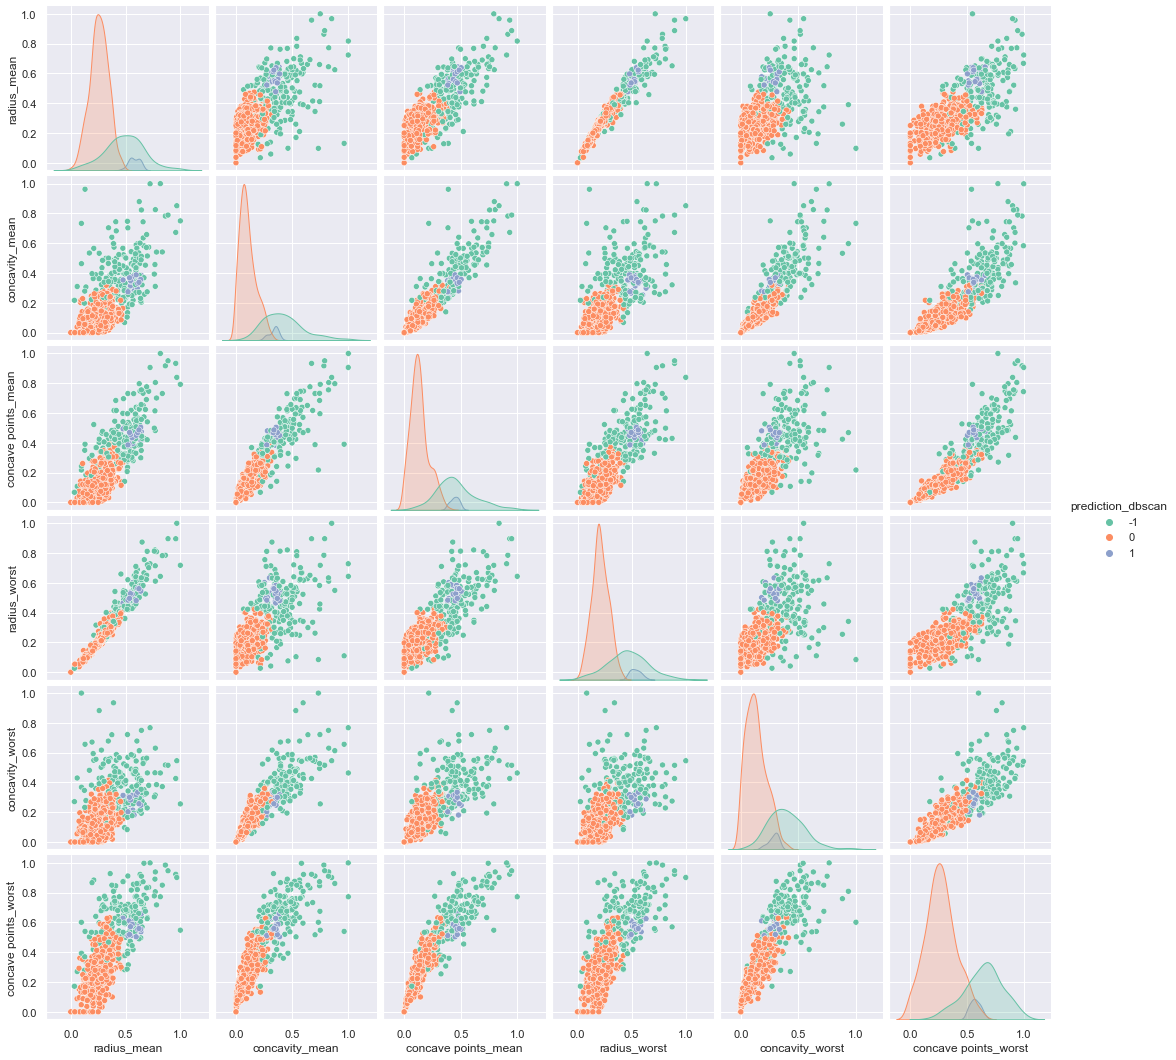

In [28]:
# Create a model with minPts=12 and epsilon=0.125
(df_dbscan_0125, sil_0125) = create_DBSCAN(df_dbscan, 0.125, 12)

# Plot the result in a scatterplot
sns.pairplot(data=df_dbscan_0125, hue="prediction_dbscan", palette="Set2")

Se observa que al emplear epsilon=0.125, los clusters que nos aparecían a la izquierda son de una zona que se puede confundir entre tumores benignos y malignos, pero con el conocimiento que tenemos de los datos clasificados, decidimos asignarlos a los tumores malignos. Esto también se hace así con el objetivo previamente comentado de minimizar el número de falsos negativos, los cuales tendrían un impacto muy grande en el paciente.

A continuación evaluamos el modelo con epsilon=1.15.

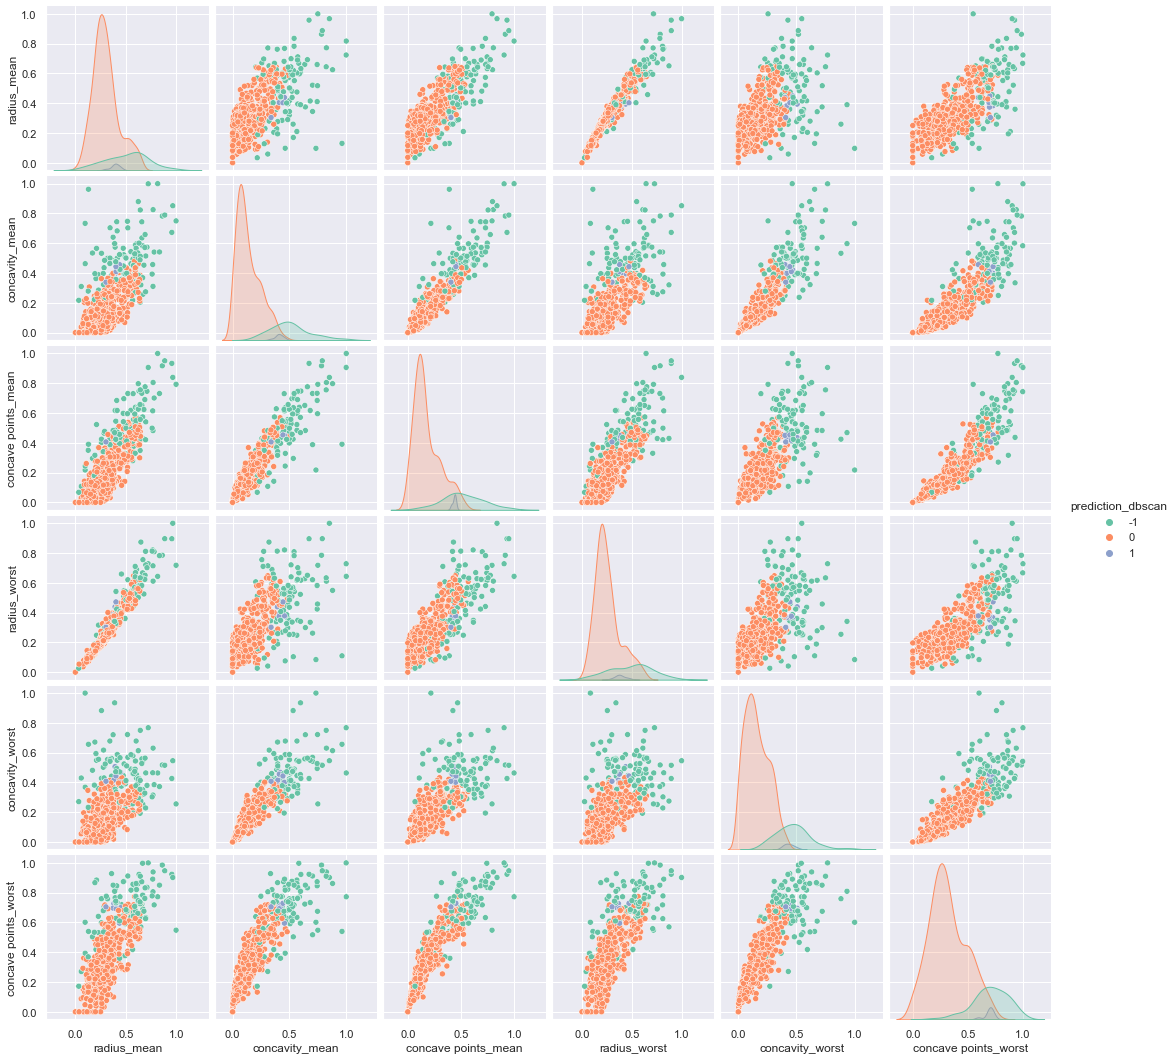

In [29]:
# Create a model with minPts=12 and epsilon=0.15
(df_dbscan_015, sil_015) = create_DBSCAN(df_dbscan, 0.15, 12)

# Plot the result in a scatterplot
sns.pairplot(data=df_dbscan_015, hue="prediction_dbscan", palette="Set2")

Se observa que con ambos valores de epsilon

Con esto se observa que el grupo 1 parece corresponder al grupo de los tumores benignos, mientras que los outliers (-1) y el grupo 1 se asignarán a los tumores malignos. A pesar de poder reducir la cálidad del modelo resultante estas medidas minimizarán el número de falsos negativos que es lo más importante a la hora de realizar este modelo predictivo.

A continuación, se evaluará la calidad del modelo con ambos valores de epsilon y se tomará una decisión de cual utilizar.

## 4.4. Evaluación de la calidad del modelo

Para evaluar la calidad del modelo emplearemos Silhouette y el porcentaje de predicciones correctas del modelo. Empezamos evaluando el valor de silhouette para los dos modelos.

In [30]:
# Evaluate silhouette of both models
print("The silhouette score for the model with epsilon=0.125 is {}".format(sil_0125))
print("The silhouette score for the model with epsilon=0.15 is {}".format(sil_015))

The silhouette score for the model with epsilon=0.125 is 0.716520337985648
The silhouette score for the model with epsilon=0.15 is 0.661545230050452


Con lo que se obtiene que para el valor de 0.15 estamos perdiendo calidad, aunque esto era de esperar ya que los outliers no se consideran dentro de ningún grupo y, por tanto, con silhouette solo estamos obteniendo una información sobre el grupo de valores asignados como grupo 0 o 1, penalizando el grupo -1. Por ello el valor que será realmente relevante será el de la precisión en la predicción del modelo que se calcula a continuación.

In [31]:
def accuracy_model(df):
    # Create dataframe with the diagnosis
    df_dbscan_2 = df_2.drop(["id", "prediction", "true_prediction"], axis=1)
    df = df_dbscan_2.merge(df, how="inner", on=["radius_mean", "concavity_mean", "concave points_mean",
                                                        "radius_worst", "concave points_worst", "concavity_worst"])
    
    # Create column with the prediction with the diagnosis groups
    df["predicted"] = ""
    df.loc[df["prediction_dbscan"]==-1, "predicted"] = "M"
    df.loc[df["prediction_dbscan"]==0, "predicted"] = "B"
    df.loc[df["prediction_dbscan"]==1, "predicted"] = "M"
    
    # Evaluate if the prediction is right
    df["true_prediction"] = np.where(df["diagnosis"] == df["predicted"], True, False)
    
    # Count the number of right predictions and compute the accuracy
    right_rows = sum(df["true_prediction"])
    total_rows = df.shape[0]
    accuracy = right_rows/total_rows
    
    return (df, accuracy)

# Evaluate the accuaracy of both models


In [32]:
# Evaluation of the accuracy for the DBSCAN model using epsilon=0.125
(df_test, accuracy)=accuracy_model(df_dbscan_0125)
print("The accuracy for the model using an epsilon of 0.125 is {0:.1%}".format(accuracy))

# Evaluation of the accuracy for the DBSCAN model using epsilon=0.15
(df_test, accuracy)=accuracy_model(df_dbscan_015)
print("The accuracy for the model using an epsilon of 0.15 is {0:.1%}".format(accuracy))

The accuracy for the model using an epsilon of 0.125 is 89.1%
The accuracy for the model using an epsilon of 0.15 is 78.0%


Al evaluar la precisión de los modelos se obtiene que la precisión del modelo con epsilon=0.125 es del 89% mientras que el que emplea epsilon=0.15 es del 78%. Esta disminución de la calidad se hace a base de añadir observaciones malignas al grupo de las benignas, ya que al aumentar epsilon lo que estamos haciendo es aumentar la distancia a la que se pueden encontrar las anomalías para englobarlas en un cluster, que en este caso significa introducirlas como un diagnóstico benigno.

Dado que al considerar una epsilon=0.125 obtenemos una mayor precisión y además minimizamos el número de falsos negativos, este es el valor que tomaremos para epsilon.

Por tanto, tras el trabajo realizado se concluye que los valores a escoger para el modelo generado con DBSCAN deben ser minPts=12 y epsilon=0.125.

## 4.5. Comparativa con otros métodos

Los modelos basados en densidad a diferencia de los basados en distancia (como k-means) no parten de un número determinado de clústers, sino que los generan a partir de zonas de alta densidad. Esta densidad se la proporcionamos nosotros mediante epsilon y minPts, que determinan cuantos puntos se deben encontrar en un radio determinado para considerarlo un cluster.

Esta definición, ha hecho que el factor de que todos las muestras se congregen en un único cluster hacía difícil detectar la diferencia entre las dos categorías con este modelo y al final se ha acabado detectando que los datos más similares correspondían a los tumores benignos, mientras que cualquier anomalía los acababa situando como outliers y se asignaban al grupo de tumores malignos.

A diferencia de otros modelos basados en distancias, como los del ejercicio 1 y 2 nos ha generado la complicación comentada previamente, no obstante, también nos ha permitido indagar más en las causas de que un tumor termine siendo diagnosticado como maligno, aunque generalización en las anomalías ya se detectó en el ejercicio 2 cuando el modelo con métrica de Chebyshev daba tan buenos resultados, identificando una independencia de los atributos.

No obstante, este modelo, aunque proporciona unos resultados muy buenos con una precisión del 89%, se queda por detrás de los modelos previos que superaban el 93% de precisión. Además generar este modelo escogiendo de forma apropiada los valores de minPts y epsilon es complejo y como se ha observado con un aumento de epsilon a 0.15 la calidad del modelo ha disminuido hasta el 78%, por lo que hay que vigilar con la sensibilidad del modelo a una modificación en estos valores. Esto no sucede con los modelos basados en distancia.

Podríamos concluir que este modelo nos aporta información nueva de los datos, pero con una mayor complejidad y una precisión ligeramente inferior a la obtenida con los modelos basados en distancia.

## 4.6. Conclusiones

En este ejercicio se ha aplicado un modelo no supervisado de clustering basado en distancia OPTICS y DBSCAN con el objetivo de predecir el diagnóstico de los tumores de pecho de un conjunto de pacientes. Además se ha buscado comparar la eficiencia de este modelo con los modelos no supervisados de clustering basados en distancia empleados previamente como k-means.

Se ha comenzado evaluando los valores apropiados de epsilon mediante un modelo de densidad OPTICS con el cual se ha obtenido una primera conclusión de nuestro conjunto de datos. Se ha observado que a diferencia de como se suelen considerar los outliers, en nuestro caso queríamos detectar una anomalía no distintos grupos de datos, por ello se ha buscado generar un único cluster que englobase las características de los tumores benignos y, a continuación, determinar que los outliers, es decir, aquellas observaciones que el valor de alguno de sus atributos difiera del cluster principal serán clasificados como tumores malignos, lo cual coincide con nuestro conocimiento de estos tumores, además de como se ha mencionado previamente queda contrastado con los resultados encontrados en el ejercicio 2. 

De este primer modelo se ha obtenido que el número adecuado de puntos sería 12 y se han dejado dos valores de epsilon (0.125 y 0.15) para evaluarlos en profundidad con DBSCAN. Todo esto siempre teniendo en cuenta nuestro objetivo de minimizar los falsos negativos como se ha mencionado previamente.

Por otro lado se ha evaluado con DBSCAN este conjunto de datos, y se ha acabado concluyendo que un valor de epsilon de 0.125 era el más apropiado ya que reducía el número de falsos negativos y además aumentaba la precisión del modelo, la cual ha terminado siendo del 89%.

# 5. Ejercicio 4

## 5.1. Introducción

En este ejercicio se va a generar un modelo de árbol de decisión con el que se obtendrán unas reglas con las que podremos determinar si un tumor se debe clasificar como benigno o maligno. 

Además se va a evaluar el modelo obtenido y se van a generar unas matrices de confusión que nos permitirán comprender el tipo de errores que comete el modelo para poder tratarlas.

Finalmente se compararan los resultados con los de otros modelos buscando las ventajas e inconvenientes que este ofrece.

## 5.2. Generación de un árbol de decisión

Para empezar vamos a generar un árbol de decisión sobre el conjunto de datos df_2 que hasta este momento ha dado muy buenos resultados y contiene unos atributos con sentido físico, lo que nos ayudará a la hora de encontrar las reglas de decisión poder implementarlas y darles un sentido físico.

Primero de todo nos será de gran utilidad conocer el porcentaje de pacientes con un diagnóstico maligno y benigno en nuestro dataset, para poder determinar si la división de los datos en grupos aleatorios es representativo.

A continuación se genera el árbol de decisión.

In [33]:
# Create dataframe to use in this exercise
df_dt = df_2.drop(["id", "prediction", "true_prediction"],axis=1)

df_dt.loc[df_dt.diagnosis == "B", "diagnosis"] = 0
df_dt.loc[df_dt.diagnosis == "M", "diagnosis"] = 1

df_dt["diagnosis"] = df_dt["diagnosis"].astype("int")

# Percentage of malign and benign diagnosis
benign = df_dt[df_dt["diagnosis"] == 0].shape[0]
total = df_dt.shape[0]

benign_pct = benign/total
malign_pct = 1 - benign_pct

# Show the results
print("{0:.1%} ({1}) of the observations correspond to a benign tumor, while {2:.1%} ({3}) correspond to a malign one"
     .format(benign_pct, benign, malign_pct, (total-benign)))

print(df_dt.diagnosis.dtypes)

62.7% (357) of the observations correspond to a benign tumor, while 37.3% (212) correspond to a malign one
int64


Con esto ya establecemos que aproximadamente el 63% de las observaciones corresponen a pacientes con tumores beignos.

A continuación, se genera el árbol de decisión.

In [34]:
# Save the features dataframe and the goal serie
y = df_dt.diagnosis
X = df_dt.drop("diagnosis", axis=1)

# Assign the different group of training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=23)

# Evaluate if the random group is representative
y_train.value_counts()

0    242
1    139
Name: diagnosis, dtype: int64

Como se puede observar se obtiene que el 63,5% de las muestras tienen un diagnóstico benigno, que comparado con el 62,7% del conjunto total nos indica que la muestra escogida es representativa.

A continuación, definimos una función para generar un árbol de decisión de una profundidad determinada.

In [35]:
def decision_tree(depth):
    # Generate the model and fit it with the training data
    clf = tree.DecisionTreeClassifier(max_depth = depth, random_state = 2) 
    clf = clf.fit(X_train, y_train)
    
    # Evaluate the precission of the model
    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    
    # Accuracy
    acc_test = metrics.accuracy_score(y_test, y_pred_test)
    acc_train = metrics.accuracy_score(y_train, y_pred_train)
    
    return (acc_test, acc_train, clf)

El árbol de decisión puede tener distintos grados de profundidad, en nuestro caso, puede llegar a ser de 6 grados, al tener 6 variables distintas. A continuación, vamos a evaluar la calidad de este para distintos grados de profundidad tratando de determinar cual es la profundidad óptima tratando de evitar el problema del overfitting.

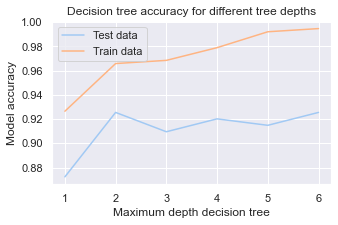

In [36]:
# List containing the accuracy of the different models
model_accuracy_train = []
model_accuracy_test = []


# Loop that generates a model and evaluates it for different depths
for i in range(6):
    acc = decision_tree(i+1) 
    model_accuracy_test.append(acc[0])
    model_accuracy_train.append(acc[1])

# Show the accuracy in a plot 
# Assign figure dimensions 
plt.figure(figsize=(5,3))

# Create the scatterplot
ax = sns.lineplot(x=list(range(1,7)),y=model_accuracy_test, label="Test data")
ax = sns.lineplot(x=list(range(1,7)),y=model_accuracy_train, label="Train data")

# Set title and others
plt.title("Decision tree accuracy for different tree depths")
plt.xlabel("Maximum depth decision tree")
plt.ylabel("Model accuracy")

# Plot the scatterplot
plt.show()

Se observa como a partir de una profundidad de 2 la precisión del árbol de decisión converge obteniendo unos resultados muy constantes, entorno al 92% de precisión.

Con los datos de entreno obtenemos unos resultados similares, teniendo una predicción muy buena con un solo nivel, y convergiendo a partir de una profundidad de 2 entorno al 97% de precisión.

Se opta por realizar un árbol de decisión con 3 niveles de profundidad para poder obtener un poco más de información.

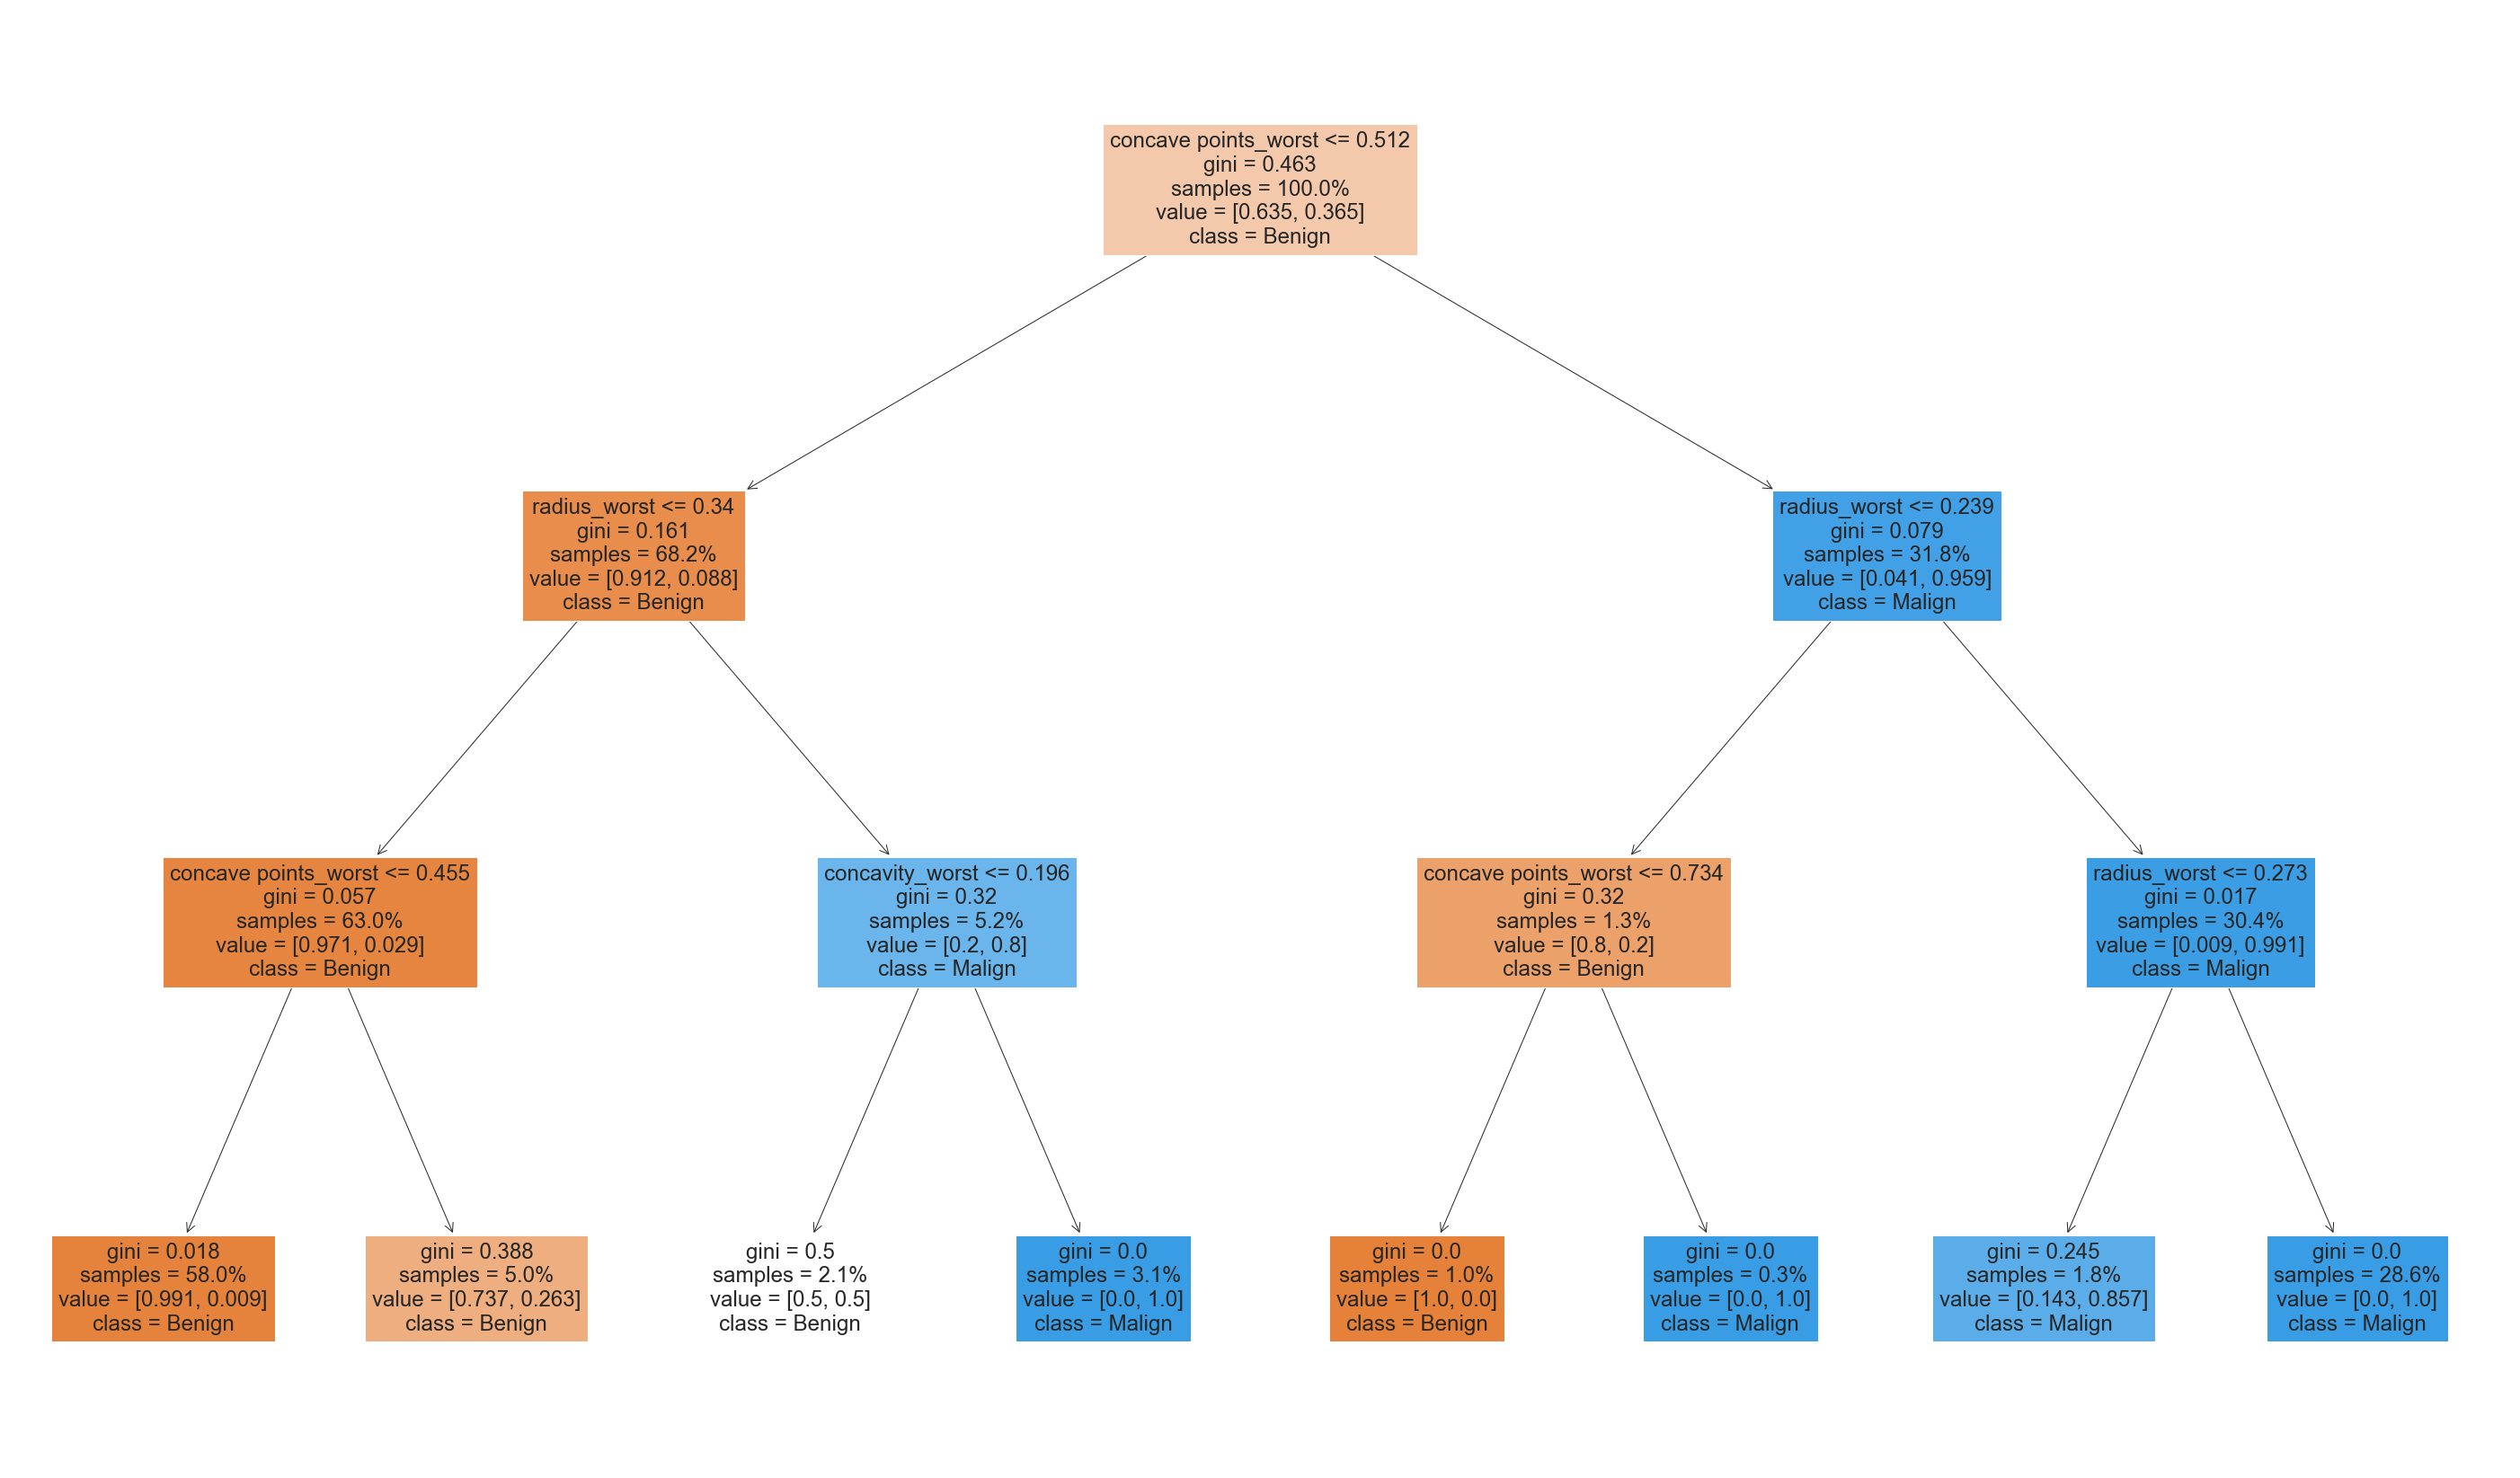

In [37]:
#Variable with feature names and class names
features = X_train.columns
classes = ["Benign", "Malign"]

# Create the figure for the the decision tree
fig = plt.figure(figsize=(50,30))

# Generate model for the decision tree
(acc_test, acc_train, clf) = decision_tree(3)
tree.plot_tree(clf, filled = True, feature_names = features, class_names =classes, proportion = True)

plt.show()

Además de la versión gráfica, también se muestra a continuación la versión textual del árbol de decisión.

In [38]:
# List with the features list
features = X_train.columns.to_list()

# Exporting to text the decision tree
r = export_text(clf, feature_names = features)
print(r)

|--- concave points_worst <= 0.51
|   |--- radius_worst <= 0.34
|   |   |--- concave points_worst <= 0.45
|   |   |   |--- class: 0
|   |   |--- concave points_worst >  0.45
|   |   |   |--- class: 0
|   |--- radius_worst >  0.34
|   |   |--- concavity_worst <= 0.20
|   |   |   |--- class: 0
|   |   |--- concavity_worst >  0.20
|   |   |   |--- class: 1
|--- concave points_worst >  0.51
|   |--- radius_worst <= 0.24
|   |   |--- concave points_worst <= 0.73
|   |   |   |--- class: 0
|   |   |--- concave points_worst >  0.73
|   |   |   |--- class: 1
|   |--- radius_worst >  0.24
|   |   |--- radius_worst <= 0.27
|   |   |   |--- class: 1
|   |   |--- radius_worst >  0.27
|   |   |   |--- class: 1



## 5.3. Reglas de decisión

Con este árbol de decisión podemos extraer las reglas de decisión de nuestro modelo para determinar si un tumor será diagnosticado como maligno o benigno.

Primero de todo hay que destacar que los valores que se van a comentar son normalizados y, por ello, simplemente nos permiten hacernos una idea de la importancia de los atributos. No se han empleado los datos sin normalizar, ya que el dataset utilizado ya venía normalizado desde su descarga y no se tiene acceso a la versión no normalizada de este.

Las reglas de decisión que se han encontrado son:
- Primero se evalua la medida de concave_points en su medición worst, que en caso de ser menor a 0.51 es un buen indicativo de que el tumor será benigno. 
- En caso de ser menor a 0.51, se obtiene que el 91% de los casos sos benignos, lo cual está muy por encima de la media. Después se evalua el radio de la medición worst el cual se evalúa si es menor a 0.34 donde el 97% de los casos serían benignos, sin enmbargo, en caso de ser superior se asignaria a un tumor maligno, en el que el 80% de los casos son malignos, una proporción muy superior a la media y, por tanto, correcta.
- En caso de que la medida de concave_points sea mayor a 0.51, se determinaría que el tumor es maligno, siendo cierto en un 96% de los casos, con lo cual es una gran medida para determinar si el tumor es maligno o no. A continuación se evaluaría el radio de la medición worst el cual en caso de ser menor a 0.239 se extraería los casos que correspondían a un tumor benigno, es decir los falsos positivos que se habrían asignado en la decisión anterior. Con esta discretización obtendriamos una cantidad de benignos del 80% en la asignación de benignos, pero lo más importante, es que la de malignos sería superior al 99%, lo cual es muy relevante, ya que con dos reglas podemos determinar que un tumor es maligno con una gran certeza.

En resumen, de este árbol de decisión obtenemos que hay dos atributos que nos permiten determinar con una precisión muy elevada si el tumor es maligno o benigno, estos son la peor medición de concave_points y la peor medición de radius, los cuales con los valores mencionados anteriormente, clasifican con una gran precisión el tumor.

## 5.4. Evaluación de la calidad del modelo

Vamos a evaluar la calidad del modelo creando una curva ROC de este

In [39]:
def calculate_ROC_curves(clf, model, show_train_ROC=False): 
    # Predict y values for the test set 
    y_pred_test = clf.predict(X_test)
    
    if show_train_ROC == True:
        y_pred_train = clf.predict(X_train)
    
    # Generate a list of 0
    ns_probs = [0 for _ in range(len(y_test))]
    
    # Calculate AUC values
    ns_auc = roc_auc_score(y_test, ns_probs)
    clf_auc_test = roc_auc_score(y_test, y_pred_test)
    
    if show_train_ROC == True:
        clf_auc_train = roc_auc_score(y_train, y_pred_train)
    
    # Generate ROC curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    clf_fpr_test, clf_tpr_test, _ = roc_curve(y_test, y_pred_test)
    
    if show_train_ROC == True:
        clf_fpr_train, clf_tpr_train, _ = roc_curve(y_train, y_pred_train)
    
    # Set figure size
    fig = plt.figure(figsize=(5,3))
    
    # Plot both curves
    plt.plot(clf_fpr_test, clf_tpr_test, label=model)
    
    if show_train_ROC == True:
        plt.plot(clf_fpr_train, clf_tpr_train, label = model + " train")
        
    plt.plot(ns_fpr, ns_tpr, label="Default solution")
    
    # Set titles and others
    plt.title("ROC Curve for the {}".format(model)) 
    plt.legend() 
    plt.xlabel("1 - Specificity") 
    plt.ylabel("Sensibility")
    
    return [clf_auc_test, model]


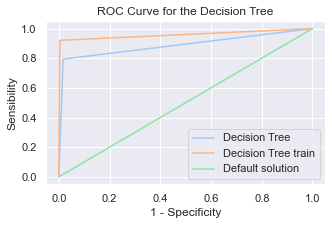

The area under de curve (AUC) for the Decision Tree model is 88.9%


In [40]:
# Calculate ROC curves
model_data = calculate_ROC_curves(clf, "Decision Tree", show_train_ROC=True)
plt.show()

print("The area under de curve (AUC) for the Decision Tree model is {0:.1%}".format(model_data[0]))

Como se puede observar la precisión del árbol de decisión es muy buena, generando una curva que alcanza un valor de sensibility muy alto para unos valores de 1 - specificity muy bajos, lo cual genera un área bajo la curva del 88,9% que son unos valores muy elevados.

A continuación se evaluará la matriz de confusión del árbol de decisión.

In [41]:
def plot_confusion_matrix(clf, model): 
    # Predict the test data 
    y_pred = clf.predict(X_test)
    
    # Generate the confusion matrix
    con_matrix = confusion_matrix(y_test, y_pred)
    
    # Format the heatmap information
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in con_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in con_matrix.flatten()/np.sum(con_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    pred_names = ["Benign", "Malign"]
   
    # Plot the confusion matrix
    fig = plt.figure(figsize = (5,3))
    ax = sns.heatmap(con_matrix, annot = labels, fmt = "", 
                     cmap="Blues", xticklabels=pred_names, yticklabels=pred_names)
    
    # Set title and axis labels
    plt.title("Confusion Matrix {}".format(model))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    
    # Plot the heatmap
    plt.show()
    
    return con_matrix

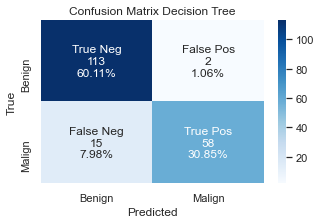

In [42]:
con_matrix = plot_confusion_matrix(clf, "Decision Tree")

In [43]:
# Store the data of the model into a dataframe:
df_supervised_models = pd.DataFrame(np.array([["Decision Tree", acc_test, model_data[0], 
                                               con_matrix[0,1], con_matrix[1,0]]]), 
                                    columns=["Model", "Accuracy", "AUC", "FP", "FN"])

En la matriz de confusión podemos observar que la precisión del modelo es muy buena, como ya se había observado con la precisión en las predicciones y con las curvas ROC, aunque aquí se vuelve a contrastar observando que tan solo hay un 9% de error. No obstante, estos errores no son tan buenos como podíamos esperar, ya que obtenemos que un 8% del error se debe a falsos negativos, que es la peor predicción que podemos hacer, ya que estaríamos dejando de tratar a un paciente con un tumor maligno, lo cual podría tener unas consecuencias muy graves.

Por ello a continuación se van a estudiar otros modelos que pueden mejorar estos resultados.

## 5.5. Modelo con Gradient Tree Boosting

El modelo Gradient Tree Boosting es un árbol de decisión que emplea un optimización de tipo boosting que consiste en entrenar árboles de decisión con los resultados obtenidos de otros árboles de decisión, de esta forma conseguimos mejorar la calidad de nuestro modelo. A continuación, se va a implementar un modelo con Gradien Tree Boosting de SciKit learn.

In [44]:
def create_gradient_tree(depth):
    # Create a model using Gradient Tree Boosting
    clf_gt = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
        max_depth=depth, random_state=0).fit(X_train, y_train)

    # Evaluate the accuracy of the model
    acc_test = clf_gt.score(X_test, y_test)
    
    return (acc_test, clf_gt)

A continuación, evaluaremos la precisión de este modelo para distintas profundidades del árbol de decisión.

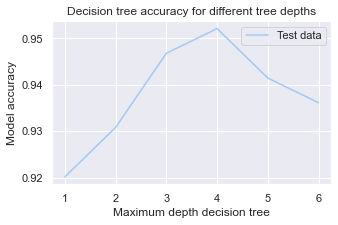

In [45]:
# List containing the accuracy of the different models
model_accuracy_test = []


# Loop that generates a model and evaluates it for different depths
for i in range(6):
    acc = create_gradient_tree(i+1) 
    model_accuracy_test.append(acc[0])

# Show the accuracy in a plot 
# Assign figure dimensions 
plt.figure(figsize=(5,3))

# Create the scatterplot
ax = sns.lineplot(x=list(range(1,7)),y=model_accuracy_test, label="Test data")

# Set title and others
plt.title("Decision tree accuracy for different tree depths")
plt.xlabel("Maximum depth decision tree")
plt.ylabel("Model accuracy")

# Plot the scatterplot
plt.show()

Se observa que este modelo obtiene su máxima precisión para una profundidad de 4, donde la precisión supera el 95%, mejorando los resultados que habíamos obtenido con el árbol de decisión inicial que era del 92%.

Por lo tanto, hasta este momento, podemos concluir que este modelo nos proporciona una mayor precisión que el previo, a continuación vamos a evaluar sus curvas ROC en comparativa con con el modelo previo y su matriz de confusión.

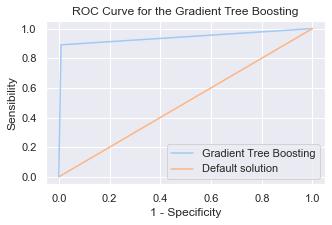

The area under de curve (AUC) for the Gradient Tree Boosting model is 94.1%


In [46]:
# Create model with a depth of 4
(acc_test, clf_gt) = create_gradient_tree(4)
# Calculate ROC curves
model_data = calculate_ROC_curves(clf_gt, "Gradient Tree Boosting")
plt.show()

print("The area under de curve (AUC) for the Gradient Tree Boosting model is {0:.1%}".format(model_data[0]))

Se observa que el área bajo la curva ROC es del 92,7% lo que representa una mejoría con respecto a la obtenida en el modelo anterior que era del 88,9%.

Finalmente, vamos a evaluar la matriz de confusión de este modelo.

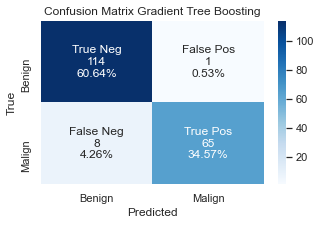

In [47]:
con_matrix = plot_confusion_matrix(clf_gt, "Gradient Tree Boosting")

In [48]:
# Store the data of the model into a dataframe:
df_supervised_models = df_supervised_models.append({"Model": "Gradient Tree Boosting",
                            "Accuracy":model_accuracy_test[3],
                            "AUC": model_data[0],
                            "FP": con_matrix[0,1],
                            "FN": con_matrix[1,0]}, ignore_index=True)

Observamos como este modelo tiene una tasa de error inferior al previo, con un error de 5,8%, no obstante, seguimos observando que la mayor parte de los errores se cometen con falsos negativos, que como habíamos comentado previamente, es el error que tenemos que minimizar. No obstante, con este modelo los resultados obtenidos tendrían una mejor calidad.

## 5.6. Modelo con Random Forest

Finalmente, con el objetivo de tratar de encontrar el mejor modelo posible se opta por realizar un modelo con Random Forest y tratar de comparar sus resultados con los previamente encontrados.

Random Forest realizar un conjunto de árboles de decisión aleatorios y buscará el promedio de sus predicciones mejorando de esta forma el resultado de un árbol de decisión. 

A la hora de aplicar el modelo de random forest se debe decidir la profundidad máxima de este, la cual se va a fijar en 3 basándonos en el estudio realizado con los árboles de decisión. Además se fijará el random_state para mejorar la reproducibilidad del código. A continuación vamos a implementarlo.

In [49]:
def random_forest(num_trees):
    # Create the random forest model
    clf_rf = RandomForestClassifier(n_estimators = num_trees, max_depth=3, random_state=23)
    clf_rf.fit(X_train, y_train)
    
    # Evaluate the precission of the model
    y_pred = clf_rf.predict(X_test)
    
    return (metrics.accuracy_score(y_test, y_pred), clf_rf)

A continuación vamos a evaluar la cantidad de árboles de decisión necesarios para que el modelo converja y, de esta forma, determinar el valor del número de árboles.

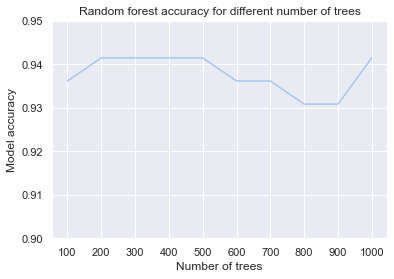

In [50]:
# List containing the accuracy of the different models
model_accuracy = []

# Loop that generates a model and evaluates it for different depths
for i in range(100, 1100, 100): 
    acc = random_forest(i) 
    model_accuracy.append(acc[0])

# Show the accuracy in a plot # Assign figure dimensions plt.figure(figsize=(5,3))
# Create the scatterplot
ax = plt.plot(model_accuracy)

# Set title and others
plt.title("Random forest accuracy for different number of trees")
plt.xlabel("Number of trees")
plt.xticks(range(10),range(100, 1100, 100))

plt.ylabel("Model accuracy")
plt.ylim([0.9, 0.95])

# Plot the scatterplot
plt.show()

Se observa que para una cantidad a partir de 100 árboles el modelo ya ha convergido con una precisión entorno al 94%, se escogerá como valor para esta variable 200, ya que parece que es donde obtenemos la mayor precisión. A continuación generamos el modelo y lo almacenamos para emplearlo más adelante.

In [51]:
(acc_rf, clf_rf) = random_forest(200)
print("La precisión del modelo random forest con 200 árboles de decisión es del {:.1%}".format(acc_rf))

La precisión del modelo random forest con 200 árboles de decisión es del 94.1%


A continuación evaluaremos las curvas ROC del modelo.

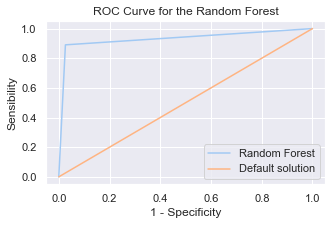

The area under de curve (AUC) for the Random Forest model is 93.2%


In [52]:
# Calculate ROC curves
model_data = calculate_ROC_curves(clf_rf, "Random Forest")
plt.show()

print("The area under de curve (AUC) for the Random Forest model is {0:.1%}".format(model_data[0]))

Se observa que el área bajo la curva del modelo con Random Forest es del 93,2%, lo cual es aún mejor que los resultados obtenidos para Gradient Tree Boosting model que era del 92,7%. No obstante, todos los modelos están ofreciendo unos resultados muy buenos.

Finalmente, buscaremos la matriz de confusión.

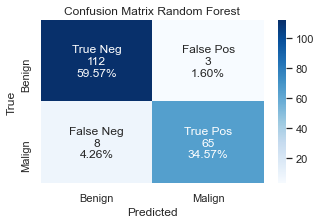

In [53]:
con_matrix = plot_confusion_matrix(clf_rf, "Random Forest")

In [54]:
# Store the data of the model into a dataframe:
df_supervised_models = df_supervised_models.append({"Model": "Random_forest",
                            "Accuracy":model_accuracy[1],
                            "AUC": model_data[0],
                            "FP": con_matrix[0,1],
                            "FN": con_matrix[1,0]}, ignore_index=True)

Para random forest observamos que el porcentaje de error es idéntico al encontrado con Gradient Boosting Tree, no obstante, estos resultados son mejores para nuestro proyecto, ya que estamos reduciendo el número de falsos negativos y, en contrapartida, aumentando el número de falsos positivos, los cuales habíamos determinado que no eran tan malos.

Finalmente, podemos concluir que estos resultados son mejores que el árbol de decisión inicial y ligeramente mejor que el modelo obtenido con Gradient Boosting Tree.

## 5.7. Comparación de los distintos modelos

In [55]:
df_supervised_models

Model            Accuracy                 AUC FP  FN
0           Decision Tree  0.9095744680851063  0.8885646217986898  2  15
1  Gradient Tree Boosting            0.952128            0.940858  1   8
2           Random_forest            0.941489            0.932162  3   8

En este ejercicio se han realizado múltiples modelos empleando 3 algoritmos distintos basados en árboles de decisión que han sido Decision Tree, Gradient Tree Boosting y Random Forest para comparar sus diferencias.

Primero de todo hay que indicar que los tres modelos han ofrecido una calidad extremadamente alta y que la comparativa se va a basar en escoger la mejor opción entre estos, aún sabiendo que todos son buenos.

Decision tree es el modelo que se generará más rápido, ya que excusivamente calculará un árbol de decisión. No obstante, también es el modelo que proporciona los resultados con menor calidad.

A continuación se ha empleado el modelo Gradient Tree Boosting que introduce el Boosting en los árboles de decisión, lo que significa que generá varios modelos de árbol de decisión iterativos aprovechando las conclusiones de uno para mejorar los resultados del siguiente. 

Con este modelo se ha observado que la calidad del modelo aumentaba consiguiendo una precisión del 95,2% respecto al 91% del modelo original, además al evaluarlo con las curvas ROC el área bajo la curva ha sido del 92,7% respecto el 88,9% del modelo original. Por tanto se puede concluir que este modelo ha realizado una mejor predicción. Por otro lado, al analizar su matriz de confusión se observa que se ha reducido el número de falsos negativos lo cual es muy importante en este proyecto.

Por otro lado, se ha evaluado un modelo con Random Forests que genera un conjunto de árboles de decisión y obtiene el promedio de los resultados. Con este modelo hemos encontrado unos resultados de precisión ligeramente inferiores a los de Gradient tree Boosting (94,1%), pero mejores resultados en el área bajo la curva ROC, siendo esta del 93,2%. No obstante, lo más importante es que este modelo reduce ligeramente el número de falsos negativos, lo cual es muy importante en este proyecto.

## 5.8. Conclusiones

En este ejercicio se ha buscado generar un modelo de árbol de decisión que nos proporcionase unas reglas de decisión para nuestro proyecto. Además, de forma complementaría se han generado otros modelos con algoritmos más complejos para tratar de mejorar la calidad del árbol de decisión.

Primero se ha evaluado un model de árbol de decisión empleando el algoritmo de Decision Tree de Scikit Learn, con este se han obtenido unos resultados muy buenos de precisión, siendo ligeramente inferiores a los encontrados con los modelos no supervisados, siendo esta del 91%.

A continuación, se han evaluado las reglas de decisión que nos proporciona el proyecto remarcando la importancia de dos atributos, **concavity_points** y **radius** ambas pertenecientes a la lectura **worst**. Con tan solo estas dos variables el filtrado de los datos era extremadamente bueno. No obstante, el dataset del que se partió en la práctica anterior ya tenía los datos normalizados, por lo que no ha sido posible evaluar los valores reales de estas variables sino tan solo su valor tras la normalización.

Para medir la calidad de este modelo se ha buscado sus curvas ROC y la matriz de confusión, de lo que se han obtenido unos resultados muy satisfactorios como ya era de esperar, encontrando un área bajo la curva del 88,9%. Al analizar la matriz de confusión es donde se ha encontrado el único aspecto negativo (dentro de su calidad extremadamente alta), la mayor parte de los errores en la predicción eran falsos negativos, los cuales nos interesa minimizar en nuestro análisis.

Finalmente, se ha comparado este modelo con otras algoritmos más complejos como Gradient Tree Boosting que introduce el factor del boosting y Random Forest, que genera un conjunto de árboles de decisión y busca su promedio. Con estos se ha encontrado que ambos modelos mejoraban la calidad del árbol de decisión y disminuian el número de falsos negativos, especialmente con Random Forest. Además se ha realizado una comparativa de estos 3 modelos.

# 6. Ejercicio 5

## 6.1. Introducción

En este ejercicio se va a generar un modelo supervisado diferente a los anteriores con el objetivo de comparar sus resultados con los modelos supervisados del ejercicio 4.

Entre los distintos modelos supervisados de clustering se ha optado por emplear k-NN, debido a las limitaciones del enunciado que requerían que estuviese incluido en el material docente. 

k-NN es un modelo muy sencillo, que se clasifica dentro de los modelos de aprendizaje vagos, ya que no tiene fase de entrenamiento. El modelo consiste en asignar a una muestra la etiqueta mayoritaría de las k muestras vecinas más cercanas.

La desventaja principal de este modelo es su lentitud en la fase de predicción debido a que tiene que encontrar la distancia de la nueva muestra a todos los puntos.

Para un correcto funcionamiento del modelo los atributos deben ser continuos y estar normalizados, lo cual ya tenemos hecho con nuestro conjunto de datos.

Como complemento se puede utilizar un modelo ponderado, weighted k-NN, donde se da más importancia a los vecinos más cercanos.

A continuación vamos a generar un modelo de k-NN y evaluaremos su calidad.

## 6.2. Modelo k-NN

Generamos los datos de entreno y de test para el modelo [6].

In [56]:
# Create dataframe to use in this exercise
df_dt = df_2.drop(["id", "prediction", "true_prediction"],axis=1)

"""
df_dt.loc[df_dt.diagnosis == "B", "diagnosis"] = 0
df_dt.loc[df_dt.diagnosis == "M", "diagnosis"] = 1

df_dt["diagnosis"] = df_dt["diagnosis"].astype("int")
"""

# Save the features dataframe and the goal serie
y = df_dt.diagnosis
X = df_dt.drop("diagnosis", axis=1)

# Assign the different group of training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=23)

A continuación definimos una función que genere los modelos de k-NN.

In [57]:
def create_knn(neighbors, weight="uniform", dist="minkowski"):
    # Create a model of k neighbors
    knn = KNeighborsClassifier(n_neighbors=neighbors, weights=weight, metric=dist)
    knn.fit(X_train, y_train)
    
    # Predict the results
    y_pred = knn.predict(X_test)
    
    # Evaluate the quality of the model
    acc = metrics.accuracy_score(y_test, y_pred)
    
    return (knn, acc)

El modelo de k-NN requiere que se pase como parámetro el número de vecinos que se tendrán en cuenta, este es un valor que hay que ajustar en función de nuestro modelo, a continuación se va a realizar un estudio de la precisión de las predicciones en función de este valor, con el objetivo de escoger el que nos proporcione la mayor precisión.

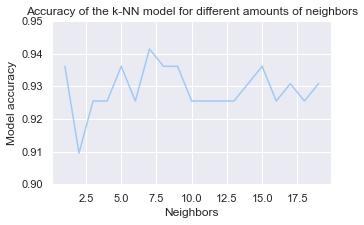

In [58]:
# List to store the accuracy of the models and to store the neighbors used
accuracy_list = []
neighbors_list = list(range(1,20))

# Iterate over the neighbors list to find the accuracy of each model.
for i in neighbors_list:
    (knn, acc) = create_knn(i)
    accuracy_list.append(acc)


# Show the accuracy in a plot 
# Assign figure dimensions 
plt.figure(figsize=(5,3))

# Create the scatterplot
ax = sns.lineplot(x=neighbors_list,y=accuracy_list)

# Set title and others
plt.title("Accuracy of the k-NN model for different amounts of neighbors")
plt.xlabel("Neighbors")
plt.ylabel("Model accuracy")
plt.ylim([0.9, 0.95])

# Plot the scatterplot
plt.show()

Se observa que la precisión del modelo no varia mucho con el número de vecinos, encontrándose su valor entre 91 y 94%, siendo en todos los casos cercana al 93% excepto para 2 vecinos. Con esto se tomará un número de vecinos igual a 7 que es la que nos proporciona la mayor calidad. A continuación se genera el modelo definitivo.

In [59]:
(knn, acc) = create_knn(7)

print("The accuracy of the k nearest neighbors using 7 neighbors is {:.1%}".format(acc))

The accuracy of the k nearest neighbors using 7 neighbors is 94.1%


Se observa que la precisión del modelo es muy elevada, siendo uno de los mejores modelos que se han probado hasta el momento. 

A continuación, se va a mostrar como separa clasificaría este modelo el total de nuestros datos empleando un pairplot.

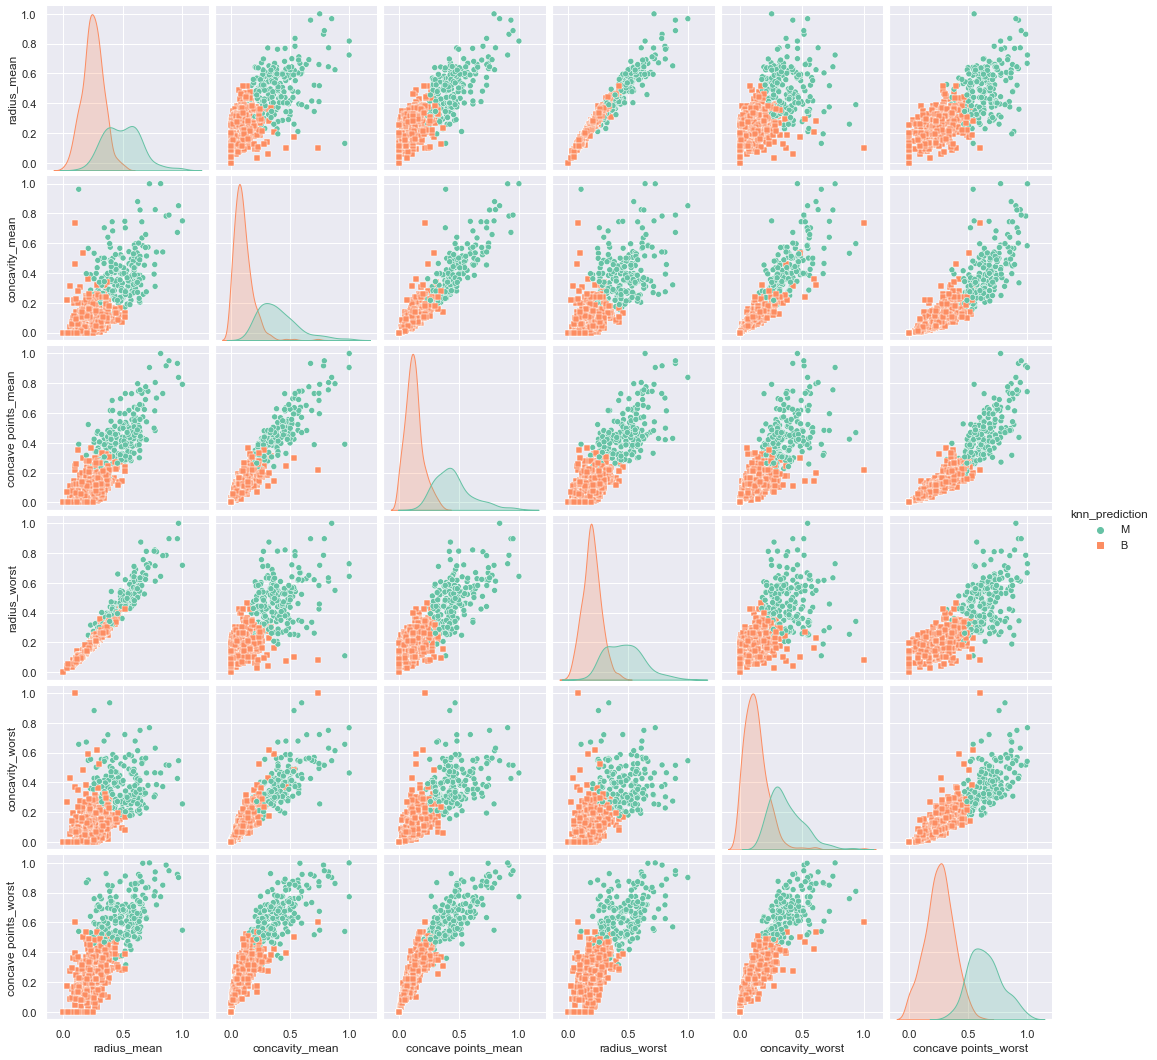

In [60]:
# Get data for the entire dataset
y_predicted = knn.predict(X)

# Create dataset with the predictions and the data
df_knn = X.copy()
df_knn["knn_prediction"] = y_predicted

# Create a scatterplot of the dataframe
sns.pairplot(df_knn, kind="scatter", hue="knn_prediction", markers=["o", "s"], palette="Set2")
plt.show()

Se observa como los resultados obtenidos son los esperados, a continuación se va a realizar un nuevo pairplor pero esta vez identificando los datos mal asignados, para tratar de identificar cuales son las fuentes de error para este algoritmo.

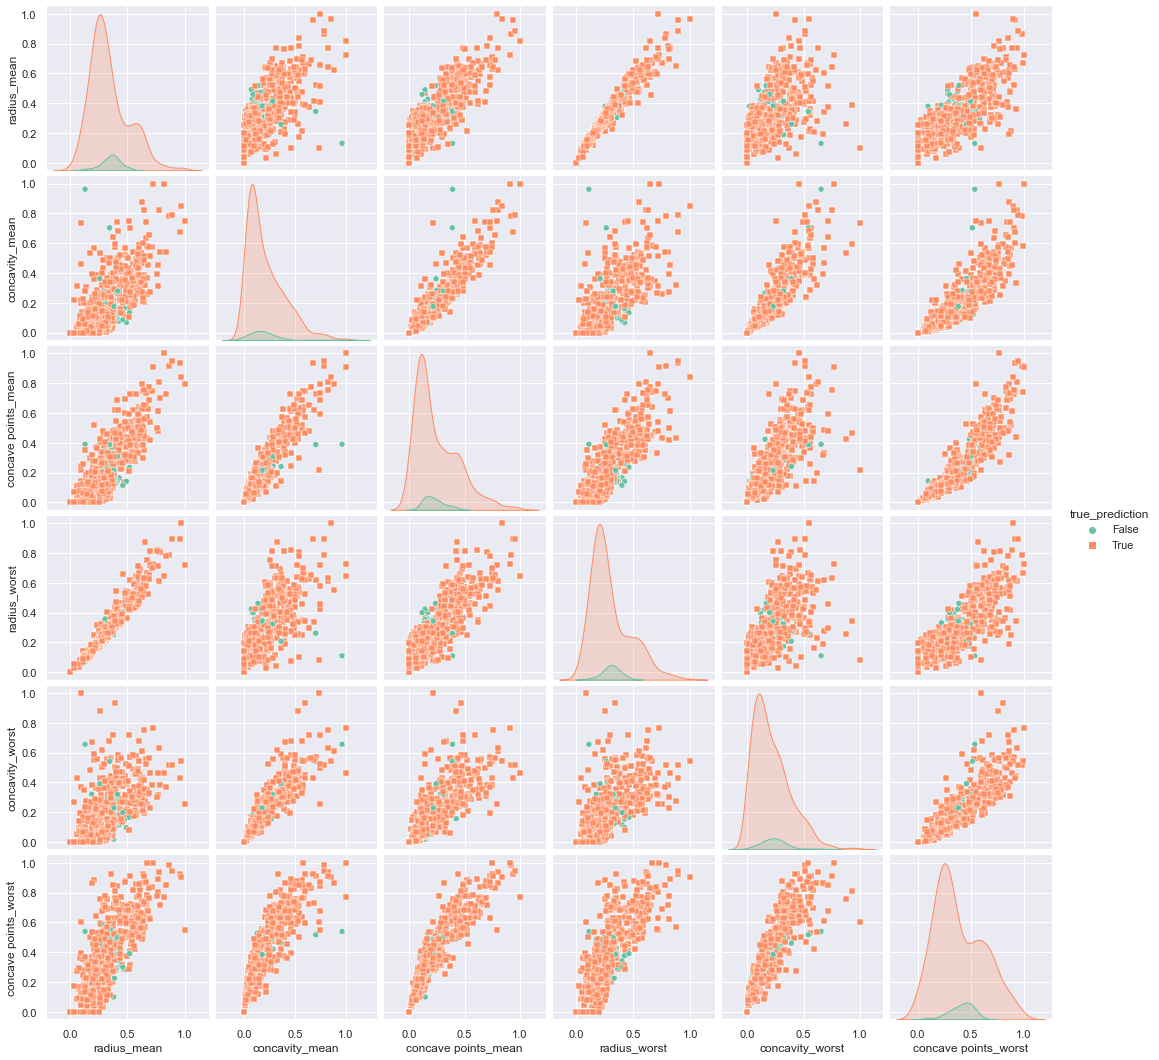

In [61]:
# Add diagnosis column to the dataframe
df_knn = df_knn.merge(df_2, how="inner", on=["radius_mean", "concavity_mean", "concave points_mean",
                                                        "radius_worst", "concave points_worst", "concavity_worst"])

# Drop columns that are in the dataframe from other models
df_knn = df_knn.drop(["prediction", "true_prediction", "id"], axis=1)

# Add column showing if the prediction is right or worng
df_knn["true_prediction"] = np.where(df_knn["diagnosis"] == df_knn["knn_prediction"], True, False)

# Scatterplot showing the wrong predicted values
sns.pairplot(df_knn.drop("diagnosis",axis=1),kind="scatter", hue="true_prediction", markers=["o", "s"], palette="Set2")
plt.show()

Se observa que los datos que se han asignado de forma incorrecta pertenecen a la zona de transición entre los dos conjuntos, tal y como era de esperar, ya que es en estos valores donde una observación puede tener como vecinos más cercanos observaciones etiquetadas como maligno o como falso.

De estos resultados se concluye que los mejores resultados se obtendrán cuando los clusters este separados y bien diferenciados, al igual que con otro modelos.

## 6.3. Modelo weighted k-NN

Tratando de ampliar lo solicitado en el ejercicio se opta por aplicar un modelo más complejo que consiste en ponderar los valores de los vecinos más cercanos. Vamos a implementar este modelo adicional con el objetivo de comparar sus resultados con los obtenidos previamente con el modelo k-NN y poder evaluar su eficacia en este proyecto.

Esta variante de k-NN se incluye en el mismo algoritmo que hemos utilizado previamente añadiendo el parámetro weights. A continuación aplicamos esta variación.

In [62]:
(knn_w, acc) = create_knn(7, "distance")

print("The accuracy of the weighted k nearest neighbors using 7 neighbors is {:.1%}".format(acc))

The accuracy of the weighted k nearest neighbors using 7 neighbors is 94.1%


Obtenemos el mismo resultado que con el modelo anterior, a continuación mostraremos un gráfico con la precisión en función del número de vecinos para evaluar si este modelo nos ofrece una mayor precisión con otra cantidad de vecinos.

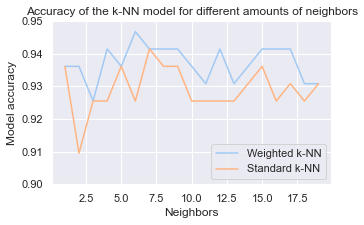

In [63]:
# List to store the accuracy of the models and to store the neighbors used
accuracy_list_w = []
neighbors_list = list(range(1,20))

# Iterate over the neighbors list to find the accuracy of each model.
for i in neighbors_list:
    (knn, acc) = create_knn(i, "distance")
    accuracy_list_w.append(acc)


# Show the accuracy in a plot 
# Assign figure dimensions 
plt.figure(figsize=(5,3))

# Create the scatterplot
ax = sns.lineplot(x=neighbors_list,y=accuracy_list_w, label = "Weighted k-NN")
ax = sns.lineplot(x=neighbors_list,y=accuracy_list, label = "Standard k-NN")

# Set title and others
plt.title("Accuracy of the k-NN model for different amounts of neighbors")
plt.xlabel("Neighbors")
plt.ylabel("Model accuracy")
plt.ylim([0.9, 0.95])
plt.legend()

# Plot the scatterplot
plt.show()

Observamos como el valor para 7 vecinos es idéntico, pero para el resto de vecinos el modelo se comporta mejor o igual que la versión no ponderada.

Por ello, concluimos que la versión ponderada nos da unos valores más precisos que la no ponderada.

In [64]:
(knn_w, acc) = create_knn(6, "distance")

print("The accuracy of the weighted k nearest neighbors using 6 neighbors is {:.1%}".format(acc))

The accuracy of the weighted k nearest neighbors using 6 neighbors is 94.7%


## 6.5. Evaluación de k-NN con diferentes distancias

En este modelo podemos emplear distintas métricas para evaluar la distancia a los vecinos más cercanos, por ello se ha decidido hacer un estudio de cual es la métrica que nos proporcionará los mejores resultados en este proyecto, siguiendo lo estudiado en el ejercicio 2, pero con un modelo supervisado.

A continuación se analizarán los resultados para 4 métricas distintas tratando de ver si se obtienen mejores resultados que en el caso previo. Todos ellos se van a realizar sobre un modelo k-NN ponderado con 6 vecinos. En el modelo previo se empleó la métrica Minkowski que es la que utiliza k-NN por defecto.

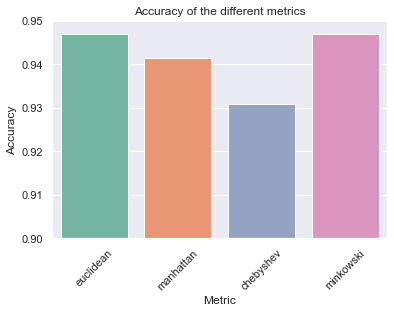

In [65]:
# List to store the accuracy of the models and to store the neighbors used
accuracy_list_d = []
metrics_list = ["euclidean", "manhattan", "chebyshev", "minkowski"]

# Iterate over the neighbors list to find the accuracy of each model.
for metric in metrics_list:
    (knn, acc) = create_knn(6, weight="distance", dist=metric)
    accuracy_list_d.append(acc)

# Plot the silhouette score into a barplot
sns.barplot(x=metrics_list, y=accuracy_list_d, palette = "Set2")
plt.title("Accuracy of the different metrics")

plt.xlabel("Metric")
plt.xticks(rotation = 45)

plt.ylabel("Accuracy")
plt.ylim([0.90, 0.95])

# Plot the barplot
plt.show()

Tras analizar las distintas métricas se obtiene que la métrica Minkowski y la Euclidea son las que proporcionan mejores resultados, con exactamente la misma precisión. La métrica Manhattan da unos resultados ligeramente inferiores y Chebyshev es la que proporciona los peores resultados de las estudiadas.

Estos resultados son interesantes, ya que la métrica Chebyshev había resultado ser la mejor por detrás de Chi-square para los modelos no supervisados y la métrica Euclidea había dado unos resultados intermedios.

In [66]:
(knn_w, acc) = create_knn(6, "distance", "minkowski")

print("The accuracy of the weighted k nearest neighbors using 6 neighbors is {:.1%}".format(acc))

The accuracy of the weighted k nearest neighbors using 6 neighbors is 94.7%


## 6.4. Comparación de los modelos

En este ejercicio se han realizado modelos de clasificación utilizando el algoritmo de scikit learn KNeighborsClassifier en su versión estándar y ponderada. Se han obtenido unos resultados ligeramente mejores en la versión ponderada con una precisión del 94,7%.

Con estos resultados se obtiene que este modelo es que nos ha proporcionado una mayor precisión de los modelos supervisados, comparado con el 93,2% obtenido con el modelo de Random Forests, que era el mejor hasta el momento.

No obstante este modelo sabemos que puede ser complejo cuando aumentemos el número de muestras ya que al tener que calcular la distancia de cada muestra que queramos predecir a todas las muestras del dataset esto hará que en datasets muy grandes cualquier predicción sea muy costosa, mientras que con los modelos previos será muy sencillo generar una predicción ya que como habíamos visto tan solo deberemos evaluar 3 o 4 atributos para poder clasificar una observación.

Por otro lado, este modelo tiene una gran desventaja en comparación con los árboles de decisión y es que estos nos proporcionan unas reglas de decisión que nos aportan mucha información respecto nuestro conjunto de datos, mientras que con k-NN no obtenemos más información del conjunto de datos.

## 6.5. Conclusiones

En este apartado se ha evaluado un modelo supervisado de clasificación distinto al empleado en el ejercicio 4. Se ha optado por estudiar un modelo k-NN. 

Primero se ha evaluado el modelo estándar del cual se han obtenido muy buenos resultados con una precisión del 94,1%, mejorando los datos de los modelos previos. Se ha decidido evaluar que datos son los que nos pueden generar errores a la hora de clasificar un dato y se ha observado que son aquellos que se encuentran en la frontera entre dos clusters, como suele pasar en la mayoría de modelo de clasificación.

A continuación se ha tratado de mejorar los datos obtenidos, primero utilizando un modelo ponderado en el que se da una mayor importancia a los vecinos más cercanos, con esto hemos conseguido aumentar la precisión del modelo hasta el 94,7%. Finalmente, se ha tratado de evaluar la influencia de la métrica, tratando de mejorar un poco más la precisión del modelo al igual que se hizo en el ejercicio 2, y se ha observado que tanto la métrica Minkowski (empleada por defecto en este modelo) como la Euclidea son las que proporcionan los mejores resultados.

Finalmente, se han comparado los resultados obtenidos en este ejercicio con los obtenidos en el ejercicio anterior y se observa que los modelos basados en árboles de decisión tienen una menor precisión que k-NN pero a cambio nos proporcionan unas reglas de decisión que pueden ser empleadas más adelante para dar un sentido físico a los datos y además en caso de tratar con un conjunto de datos grande, puede ser costoso generar el modelo pero no lo serán las predicciones, al revés que con k-NN.

# 7. Ejercicio 6

## 7.1. Limitaciones del dataset

El dataset sobre el que se ha trabajado contenía datos de distintos parámetros de tumores de pacientes que posteriormente fueron diagnosticados como malignos o benignos. 

Por un lado uno de los problemas con los que nos hemos encontrado es que el dataset ya proporcionaba los datos normalizados, por lo que no tenemos una perspectiva de las magnitudes reales de estas variables, lo cual no es un problema a la hora de evaluar los datos de un paciente con un modelo no supervisado, pero si que lo será a la hora de aplicar un modelo supervisado, ya que las reglas obtenidas en un árbol de decisión o las posiciones en k-NN no serán validas. Lo único que será práctico de un árbol de decisión será la evaluación que hace de cuales son los atributos que tienen una mayor influencia a la hora de determinar el diagnóstico de un paciente.

Se ha encontrado que el dataset no contenía ningún tipo de información al respecto del paciente como edad o factores de riesgo que podrían ayudarnos a extraer información adicional de este dataset.

Por otro lado, el dataset presentaba 3 conjuntos de datos. Los pacientes estudiados tenían múltiples tumores, de estos se tomo la lectura promedio **mean**, la peor **worst** y el error estándar **se**. Tras estudiarlas se ha observado que los datos **mean** y **worst** son redundantes y se podría haber prescindido de ellos, no obstante esta tarea se ha acabado realizando en el preprocesado de los datos, al igual que otros atributos que no aportaban mucha información.

Finalmente, la longitud del dataset era de 569 muestras, el cual es correcto, pero sería conveniente que fuese mayor para así poder obtener unos resultados más solidos.

A pesar de estas limitaciones se han obtenidos unas predicciones muy buenas que en la mayoría de los modelos excedían el 90%.

## 7.2. Riesgos de uso

Los modelos encontrados conllevan un riesgo de uso asociado ya que en este caso se estarían aplicando para el diagnóstico de tumores en pacientes que pueden sufrir cáncer. 

Es muy importante ser conscientes que estos modelos son una herramienta muy útil para que el personal especializado pueda determinar que pacientes requieren de unos estudios en mayor profundidad o tienen un riesgo superior al resto a ser diagnosticados con un cáncer, no obstante, siempre debe ser un profesional quien sabiendo que ese paciente tiene un riesgo alto o bajo de tener un diagnóstico negativo estudie el caso y obtenga las conclusiones finales.

Por otro lado, a la hora de clasificar una observación podemos cometer dos tipos de error un falso positivo, o un falso negativo. Como se ha mencionado anteriormente, un falso positivo no tiene una gran gravedad ya que en ese caso el médico realizará unas pruebas complementarias para contrarestar los resultados e identificará que fue un falso positivo. No obstante un falso negativo, podría conllevar que no se detecte un tumor maligno en un paciente enfermo y que no se actué a tiempo, cuando se sabe que en el caso del cáncer lo mejor es identificarlos en las fases iniciales. Por ello, una mejora en estos modelos debería ir en la línea de reducir el número de falsos negativos.

Finalmente, es importante remarcar, que aunque este modelo conlleve unos riesgos, también puede suceder que este procesamiento de los datos, si se realiza a partir de pruebas sencillas y económicas termine permitiendo identificar una cantidad muy elevada de pacientes de riesgo que posteriormente reciban unas pruebas más complejas para identificar a pacientes con cáncer. Por ello, conlleva unos riesgos que pueden ser contrarestados al poder tratar a un número muy superior de pacientes optimizando los recursos médicos o permitiendo el acceso a ellos en paises con menos recursos.

# 8. Bibliografia

[1] pyclustering.cluster.kmeans.kmeans Class Reference. (s. f.). Pyclustering. Recuperado 11 de enero de 2022, de https://pyclustering.github.io/docs/0.9.0/html/da/d22/classpyclustering_1_1cluster_1_1kmeans-
_1_1kmeans.html#a24cb16d166a249735bd89c6448182224

[2] pyclustering.utils.metric.type_metric Class Reference. (s. f.). Pyclustering. Recuperado 11 de enero de 2022, de https://pyclustering.github.io/docs/0.8.2/html/da/d3a/classpyclustering_1_1utils_1_1metric_1-
_1type__metric.html

[3] CHILLAR, A. (2020, 26 noviembre). KMeans Clustering using different distance metrics. Kaggle. https://www.kaggle.com/arushchillar/kmeans-clustering-using-different-distance-metrics

[4] Distance Metrics Overview. (s. f.). Improved Outcomes. Recuperado 11 de enero de 2022, de http://www.improvedoutcomes.com/docs/WebSiteDocs/Clustering/Clustering_Parameters/Distance_-
Metrics_Overview.htm

[5] Martinez, M. (2021). PEC 2 Minería de datos.

[6] sklearn.neighbors.KNeighborsClassifier. (s. f.). Scikit-Learn. Recuperado 12 de enero de 2022, de https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.-neighbors.KNeighborsClassifier.score